In [1]:
import numpy as np
import pandas as pd
import sys,os
import random
import warnings


import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

sys.path.append('../')

from unpast.utils.io import read_bic_table, write_bic_table
from unpast.utils.method import prepare_input_matrix
from unpast.utils.eval import  add_survival, add_sex

from unpast.utils.figs import draw_heatmap2

In [2]:
analysis_seed= 0
n_runs = 5
seeds = []
random.seed(analysis_seed)
for i in range(n_runs):
    seeds.append(random.randint(0,1000000))
print("generate ",n_runs," seeds",seeds)

bic_path = "../../all_cancers_results_latest/"
data_path = "/home/olya/TUM/DESMOND2/data/"
exprs_path = data_path+"/PanCan/"

passed_ids = pd.read_csv("../../data/preprocessed_v6/passed_gene_ids.txt",header=None)
passed_ids = passed_ids[0].values
passed_ids = [ x for x in sorted(set(passed_ids)) if not x =='pk' ]

suffix = "_consensus.seed=0.bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv"

max_ARI = 0.25
min_n_samples = 10

generate  5  seeds [885440, 403958, 794772, 933488, 441001]


In [3]:
len(passed_ids)

26296

In [4]:
stats = {}
all_biclusters = []

for f in sorted(os.listdir(bic_path)):
    if "consensus" in f:
        cancer  = f.split(".")[0].replace("_consensus","")
        stats[cancer] = {}
        bic_file = bic_path+"/"+cancer+suffix
        biclusters = read_bic_table(bic_file)
        stats[cancer]["n_biclusters"] = biclusters.shape[0]
        biclusters["cancer"] = cancer
        all_biclusters.append(biclusters)
all_biclusters = pd.concat(all_biclusters)     
cancers = sorted(stats.keys())
print("cancers: %s"%len(cancers))

cancers: 33


# Compare biclusters with known mol. subtypes

In [5]:
subt_dir = "../../data/preprocessed_v6/TCGAPanCan_subtypes/"
# mol subtypes
subtypes = pd.read_csv(subt_dir+"TCGASubtype.20170308.tsv.gz",sep ="\t",index_col=0)
annot_samples = set(subtypes.index.values)
print("mol. subytpes:", subtypes.shape[0])
subtypes.head(3)

mol. subytpes: 7734


,Subtype_mRNA,Subtype_DNAmeth,Subtype_protein,Subtype_miRNA,Subtype_CNA,Subtype_Integrative,Subtype_other,Subtype_Selected
sampleID,,,,,,,,
TCGA-OR-A5J1-01,steroid-phenotype-high+proliferation,CIMP-high,NaN,miRNA_1,Quiet,COC3,C1A,ACC.CIMP-high
TCGA-OR-A5J2-01,steroid-phenotype-high+proliferation,CIMP-low,1,miRNA_1,Noisy,COC3,C1A,ACC.CIMP-low
TCGA-OR-A5J3-01,steroid-phenotype-high,CIMP-intermediate,3,miRNA_6,Chromosomal,COC2,C1A,ACC.CIMP-intermediate


In [6]:
# cancers without mol. subtypes
for cancer in cancers:
    annot = pd.read_csv(exprs_path+cancer+".annotation.tsv.gz",index_col=0,sep="\t")
    if len(set(subtypes.index).intersection(set(annot.index.values)))==0:
        print(cancer)

CESC
CHOL
DLBC
MESO
PAAD
SARC
TGCT
THYM
UVM


### cancers without  mol. subtypes in the Xena table
- CESC https://ars.els-cdn.com/content/image/1-s2.0-S1535610818301193-mmc4.xlsx
- CHOL https://www.cell.com/cms/10.1016/j.celrep.2017.02.033/attachment/64b1c318-7516-4477-b21c-70fea6ff3f8e/mmc2.xlsx
- MESO http://cancerdiscovery.aacrjournals.org/content/early/2018/10/13/2159-8290.CD-18-0804
- PAAD https://www.cell.com/cancer-cell/fulltext/S1535-6108(17)30299-4
- SARC https://pmc.ncbi.nlm.nih.gov/articles/PMC5693358/#SM
- TGCT https://www.cell.com/cms/10.1016/j.celrep.2018.05.039/attachment/47e0dd36-48a8-4302-a08d-a682b9e678db/mmc2.xlsx
- THYM https://pmc.ncbi.nlm.nih.gov/articles/PMC5994906/#SD1
- UVM https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5619925/

In [7]:
# CESC
subt_cesc = pd.read_csv(subt_dir+"CESC_panGyn_1-s2.0-S1535610818301193-mmc4.csv",sep ="\t",index_col=0)
subt_cesc = subt_cesc.loc[subt_cesc["Tumor.Type"]=="CESC",:]
annot2 = pd.read_csv(exprs_path+"CESC"+".annotation.tsv.gz",index_col=0,sep="\t")
annot2["Sample.ID"] = ["-".join(x.split("-")[:-1]) for x in annot2.index]
subt_cesc = annot2.join(subt_cesc,on="Sample.ID").loc[:,[ 'CNV Clusters','Mutation Clusters', 
                                                         'DNA.Methylation Clusters', 
                                             'mRNA Clusters','miRNA Clusters', 'lncRNA Clusters', 
                                             'Protein Clusters','PARADIGM Clusters']]
print("CESC subytpes:", subt_cesc.shape[0])
subt_cesc.columns = ['Subtype_CNA','Subtype_mutations', 
                     'Subtype_DNAmeth', 'Subtype_mRNA', 'Subtype_miRNA', 'Subtype_lncRNA',
                     'Subtype_protein', 'paradigm_cluster']
subt_cesc.head(2)

CESC subytpes: 306


,Subtype_CNA,Subtype_mutations,Subtype_DNAmeth,Subtype_mRNA,Subtype_miRNA,Subtype_lncRNA,Subtype_protein,paradigm_cluster
sample,,,,,,,,
TCGA-2W-A8YY-01,C2,C8,C6,C9,C5,NaN,C5,C2
TCGA-4J-AA1J-01,C4,C9,C7,C3,C6,NaN,C5,C7


In [8]:
# CHOL
subt_chol = pd.read_csv(subt_dir+"CHOL_LIHCPAAD_mmc2.csv",sep ="\t",index_col=0)
cols = ['CN cluster k5', 'miRNA_cluster_k4','DNA_methylaiton_cluster_k7', 
        'mRNA Yulia -liver TumorMap k=7','RPPA k=6']
subt_chol = subt_chol.loc[:,cols]
annot2 = pd.read_csv(exprs_path+"CHOL"+".annotation.tsv.gz",index_col=0,sep="\t")
annot2["Sample.ID"] = ["-".join(x.split("-")[:-1]) for x in annot2.index]
subt_chol = annot2.join(subt_chol,on="Sample.ID").loc[:, cols]
print("CHOL subytpes:", subt_chol.shape[0])
subt_chol.columns = ['Subtype_CNA', 'Subtype_miRNA','Subtype_DNAmeth',
                      'Subtype_mRNA', 'Subtype_protein']
subt_chol.head(2)

CHOL subytpes: 36


,Subtype_CNA,Subtype_miRNA,Subtype_DNAmeth,Subtype_mRNA,Subtype_protein
sample,,,,,
TCGA-3X-AAV9-01,2.0,1.0,2.0,4.0,2.0
TCGA-3X-AAVA-01,1.0,2.0,3.0,5.0,6.0


In [9]:
# MESO
subt_meso = pd.read_csv(subt_dir+"MESO_21598290cd180804-sup-205173_2_supp_5073239_pg14sl.tsv.csv",sep ="\t",index_col=0)
cols = ['CN_cluster_k6', 'methylation_cluster_k3', 'mRNA_cluster_k4',
       'miRNA_cluster_k5', 'ncRNA_cluster_k4', 'RPPA_clusters_k5',
       'PARADIGM_cluster_20160301']
subt_meso = subt_meso.loc[:,cols]
subt_meso.columns = ['Subtype_CNA','Subtype_DNAmeth','Subtype_mRNA','Subtype_miRNA',
    "Subtype_lncRNA",'Subtype_protein','paradigm_cluster']
print("MESO subytpes:", subt_meso.shape[0])
subt_meso.head(2)

MESO subytpes: 74


,Subtype_CNA,Subtype_DNAmeth,Subtype_mRNA,Subtype_miRNA,Subtype_lncRNA,Subtype_protein,paradigm_cluster
TCGA_barcode,,,,,,,
TCGA-3H-AB3M-01,C1_S6,high_S2,C1_S2,C3_S4,C4_S3,C2_S4,C4_S2
TCGA-3H-AB3S-01,C1_S6,high_S2,C2_S4,C3_S4,C4_S3,C2_S4,C4_S2


In [10]:
# PAAD
subt_paad = pd.read_csv(subt_dir+"PAAD_mmc2.csv",sep ="\t",index_col=0)
cols = ['mRNA Moffitt clusters (All 150 Samples) 1basal  2classical',
        'mRNA Collisson clusters (All 150 Samples) 1classical 2exocrine 3QM',
       'mRNA Bailey Clusters (All 150 Samples) 1squamous 2immunogenic 3progenitor 4ADEX',
       'Methylation Clusters (All 150 Samples)',
       'Copy Number Clusters (All 150 Samples)',
       'miRNA Clusters (All 150 Samples)', 
       'lncRNA Clusters (All 150 Samples)',
       'RPPA Clusters (All 150 Samples)']
subt_paad = subt_paad.loc[:,cols]
subt_paad.columns = ['Subtype_mRNA','Subtype_mRNA2','Subtype_mRNA3',
                     'Subtype_DNAmeth',
                     'Subtype_CNA',
                     'Subtype_miRNA',
                     "Subtype_lncRNA",'Subtype_protein']
print("PAAD subytpes:", subt_paad.shape[0])
subt_paad.index = [x[:-1] for x in subt_paad.index]
subt_paad.head(2)

PAAD subytpes: 150


,Subtype_mRNA,Subtype_mRNA2,Subtype_mRNA3,Subtype_DNAmeth,Subtype_CNA,Subtype_miRNA,Subtype_lncRNA,Subtype_protein
TCGA-2J-AAB1-01,2,1,3,1.0,Low,2,2,NaN
TCGA-2J-AAB4-01,2,1,3,NaN,Low,2,2,NaN


In [11]:
# SARC
subt_sarc = pd.read_csv(subt_dir+"SARC_NIHMS912614-supplement-10.csv",sep ="\t",index_col=0)
cols = ['CN cluster','methylation cluster', 'mRNA cluster',
        'miRNA cluster', 'RPPA cluster', 'PARADIGM cluster',]
subt_sarc = subt_sarc.loc[:,cols]
subt_sarc.columns = ['Subtype_CNA','Subtype_DNAmeth','Subtype_mRNA','Subtype_miRNA',
    'Subtype_protein','paradigm_cluster']
print("SARC subytpes:", subt_sarc.shape[0]) 
subt_sarc.head(2)

SARC subytpes: 206


,Subtype_CNA,Subtype_DNAmeth,Subtype_mRNA,Subtype_miRNA,Subtype_protein,paradigm_cluster
TCGA barcode,,,,,,
TCGA-3B-A9HI-01,1,M1,1,2,C4,4
TCGA-3B-A9HL-01,2,M1,1,2,C5,4


In [12]:
# TGCT
subt_tgct = pd.read_csv(subt_dir+"TGCT_mmc2.csv",sep ="\t",index_col=0)
cols =  ['SCNA_k5', 'miRNA_k3', 'methylation_k5', 'mRNA_k4', 'RPPA_k4','PARADIGM_k3']
subt_tgct = subt_tgct.loc[:,cols]
subt_tgct.columns = ['Subtype_CNA','Subtype_miRNA','Subtype_DNAmeth','Subtype_mRNA',
    'Subtype_protein','paradigm_cluster']
print("TGCT subytpes:", subt_tgct.shape[0]) 
subt_tgct.head(2)

TGCT subytpes: 137


,Subtype_CNA,Subtype_miRNA,Subtype_DNAmeth,Subtype_mRNA,Subtype_protein,paradigm_cluster
sample,,,,,,
TCGA-2G-AAEW-01,1.0,1,Sem-MC,1,1.0,1
TCGA-2G-AAEX-01,1.0,1,Sem-MC,1,1.0,1


In [13]:
# THYM
subt_thym = pd.read_csv(subt_dir+"THYM_NIHMS969113-supplement-2.csv",sep ="\t",index_col=0)
subt_thym.set_index("Tumor Barcode", inplace=True)
cols = [ 'miRNA clusters (5)','methylation clusters (3)', 
        'mRNA clusters (4)', 'RPPA clusters (4)'] # ,'COCA clusters (4)'
subt_thym = subt_thym.loc[:,cols]
subt_thym.columns = ['Subtype_miRNA','Subtype_DNAmeth','Subtype_mRNA','Subtype_protein']
subt_thym.index = [x[:-1] for x in subt_thym.index]
subt_thym 

,Subtype_miRNA,Subtype_DNAmeth,Subtype_mRNA,Subtype_protein
TCGA-3G-AB0O-01,1,M3,4,C1
TCGA-3G-AB14-01,3,M2,4,C1
TCGA-3G-AB19-01,5,M1,2,C2
TCGA-3Q-A9WF-01,1,M3,4,C1
TCGA-3S-A8YW-01,2,M1,3,C1
...,...,...,...,...
TCGA-ZC-AAAA-01,3,M3,4,C1
TCGA-ZC-AAAF-01,4,M3,1,C4
TCGA-ZC-AAAH-01,1,M3,4,C1
TCGA-ZL-A9V6-01,5,M1,2,C2


In [14]:
subtypes.head(1)

,Subtype_mRNA,Subtype_DNAmeth,Subtype_protein,Subtype_miRNA,Subtype_CNA,Subtype_Integrative,Subtype_other,Subtype_Selected
sampleID,,,,,,,,
TCGA-OR-A5J1-01,steroid-phenotype-high+proliferation,CIMP-high,NaN,miRNA_1,Quiet,COC3,C1A,ACC.CIMP-high


In [15]:
# UVM
subt_uvm = pd.read_csv(subt_dir+"UVM_subtypes_PMC5619925_TS2.tsv",sep ="\t",index_col=0)
annot2 = pd.read_csv(exprs_path+"UVM"+".annotation.tsv.gz",index_col=0,sep="\t")
annot2["Sample.ID"] = ["-".join(x.split("-")[:-1]) for x in annot2.index]
subt_uvm = annot2.join(subt_uvm,on="Sample.ID").iloc[:,-6:]
print("UVM subytpes:", subt_uvm.shape[0])
subt_uvm.columns = ["Subtype_CNA","Subtype_DNAmeth","Subtype_miRNA","Subtype_lncRNA","Subtype_mRNA","paradigm_cluster"]
subt_uvm = subt_uvm.applymap(str)
subt_uvm.head(2)

UVM subytpes: 79


,Subtype_CNA,Subtype_DNAmeth,Subtype_miRNA,Subtype_lncRNA,Subtype_mRNA,paradigm_cluster
sample,,,,,,
TCGA-RZ-AB0B-01,4,4,4,4,4,4
TCGA-V3-A9ZX-01,4,4,5,4,4,4


In [16]:
# pancan clusters https://pmc.ncbi.nlm.nih.gov/articles/PMC5957518/
subsets_pancan = pd.read_csv(subt_dir+"PanCan_NIHMS957746-supplement-3.tsv.csv",sep ="\t",index_col=0)
subsets_pancan.index = ["-".join(x.split("-")[:4])[:-1] for x in subsets_pancan.index ] 
subsets_pancan["Subtype_PanCan_mRNA"] = subsets_pancan["Groups"]
subsets_pancan = subsets_pancan.loc[:,["Subtype_PanCan_mRNA"]]
subsets_pancan["sample"] = subsets_pancan.index
subsets_pancan = subsets_pancan.drop_duplicates("sample")
subsets_pancan

,Subtype_PanCan_mRNA,sample
TCGA-02-0055-01,1,TCGA-02-0055-01
TCGA-02-2483-01,1,TCGA-02-2483-01
TCGA-02-2486-01,1,TCGA-02-2486-01
TCGA-06-0125-01,1,TCGA-06-0125-01
TCGA-06-0129-01,1,TCGA-06-0129-01
...,...,...
TCGA-95-7562-01,40,TCGA-95-7562-01
TCGA-A5-A3LP-01,41,TCGA-A5-A3LP-01
TCGA-AJ-A3IA-01,41,TCGA-AJ-A3IA-01
TCGA-D7-A6EX-01,42,TCGA-D7-A6EX-01


### immune and iCluster
from Xena

In [17]:
# six immune subtypes
subtypes_imm = pd.read_csv(subt_dir+"Subtype_Immune_Model_Based.txt.gz",sep ="\t",index_col=0)
print("immune subytpes:", subtypes_imm.shape[0])
#set(imm_sig["Subtype_Immune_Model_Based"].values)

immune subytpes: 9126


In [18]:
# icluster
subtypes_icl = pd.read_csv(subt_dir+"TCGA_PanCan33_iCluster_k28_tumor.gz",sep ="\t",index_col=0)
subtypes_icl.shape[0]

9666

In [19]:
# all subytpes
subtypes = pd.concat([pd.concat([subtypes, 
                                 subt_cesc,subt_chol,subt_meso,
                                 subt_paad, subt_sarc, subt_tgct,
                                 subt_thym,subt_uvm
                                ],axis=0),
                      subtypes_imm,
                      #subtypes_icl,
                      subsets_pancan
                     ],axis=1)
subtypes = subtypes.fillna("NA")
subtypes= subtypes.applymap(str)
print(subtypes.shape[0])
subtypes.head(3)

11058


,Subtype_mRNA,Subtype_DNAmeth,Subtype_protein,Subtype_miRNA,Subtype_CNA,Subtype_Integrative,Subtype_other,Subtype_Selected,Subtype_mutations,Subtype_lncRNA,paradigm_cluster,Subtype_mRNA2,Subtype_mRNA3,Subtype_Immune_Model_Based,Subtype_PanCan_mRNA,sample
TCGA-OR-A5J1-01,steroid-phenotype-high+proliferation,CIMP-high,NA,miRNA_1,Quiet,COC3,C1A,ACC.CIMP-high,NA,NA,NA,NA,NA,Lymphocyte Depleted (Immune C4),31.0,TCGA-OR-A5J1-01
TCGA-OR-A5J2-01,steroid-phenotype-high+proliferation,CIMP-low,1,miRNA_1,Noisy,COC3,C1A,ACC.CIMP-low,NA,NA,NA,NA,NA,Inflammatory (Immune C3),31.0,TCGA-OR-A5J2-01
TCGA-OR-A5J3-01,steroid-phenotype-high,CIMP-intermediate,3,miRNA_6,Chromosomal,COC2,C1A,ACC.CIMP-intermediate,NA,NA,NA,NA,NA,Lymphocyte Depleted (Immune C4),31.0,TCGA-OR-A5J3-01


# Identify biclusters not matching known subtypes
*incl. subtypes based on other omics

In [20]:
from unpast.utils.eval import  evaluate_overlaps_ARI, apply_bh

In [21]:
not_matched_biclusters = {}
considered_classifications = ["Subtype_mRNA","Subtype_mRNA2","Subtype_mRNA3",
                              "Subtype_lncRNA", "Subtype_Immune_Model_Based","Subtype_PanCan_mRNA"
                             ]
for cancer in cancers:
    bics = all_biclusters.loc[all_biclusters["cancer"]==cancer,:].copy().loc[:,:]
    # remove biclusters with too few samples
    bics = bics.loc[bics["n_samples"]>min_n_samples,:]
    stats[cancer]['n_samples_>_'+str(min_n_samples)+"s"] = bics.shape[0]
    exprs_samples = set(pd.read_csv(exprs_path+cancer+".exprs.tsv.gz",index_col=0,sep="\t").columns)
    stats[cancer]["n_samples"] = len(exprs_samples)
    shared_samples = sorted(set(subtypes.index).intersection(exprs_samples))
    known_subts = subtypes.loc[shared_samples,:]
    # drop columns with all missing values
    known_subts = known_subts.dropna(axis=1,how="all")
    # remove columns with all the same values
    keep_cols = []
    for col in known_subts.columns:
        if len(set(known_subts[col].values))>1:
            keep_cols.append(col)
    known_subts = known_subts.loc[:,keep_cols]
    known_subts = known_subts.fillna("NA")

    bics.loc[:,"samples.all"]= bics["samples"]
    bics.loc[:,"samples"] = bics["samples"].apply(lambda x: x.intersection(shared_samples))
    bics.loc[:,"n_samples"] = bics["samples"].apply(lambda x:len(x))
    
    classification = [x for x in known_subts.columns if x in considered_classifications]
    if len(classification)>0:
        pvs = []
        aris = []
        for cls in classification:
            subt_dict = {}
            subts = [x for x in set(known_subts[cls].values) if not "NA" in x]
            if len(subts)>0:
                for subt in subts:
                    subt_dict[subt+"."+cls] = set(known_subts.loc[known_subts[cls]==subt,:].index.values)

                pv, enrich, ari = evaluate_overlaps_ARI(bics, subt_dict, shared_samples)
                pv_adj = apply_bh(pv,a=0.05)
                pvs.append(pv_adj)
                aris.append(ari)

        pvs = pd.concat(pvs,axis=1)
        aris = pd.concat(aris,axis=1)
        aris["max_ARI"] = aris[pvs<0.05].max(axis=1)
        aris["max_ARI"] = aris["max_ARI"].fillna(0)
        passed_bics_id = aris.loc[aris["max_ARI"]<=max_ARI,:].index.values
        not_matched_biclusters[cancer] = bics.loc[passed_bics_id,:]

        stats[cancer].update({"ARI":len(passed_bics_id)})
    else:
        stats[cancer].update({"ARI":np.nan})
        print("no mRNA clusters for %s"%cancer)


no mRNA clusters for DLBC


# Survival analysis
* log-Rank and CPH with covariates
* consider biclusters with at least 20 samples;
* for ["KICH", "LIHC","LUSC","TGCT","PAAD", "UVM", "DLBC"] the number of samples with stages 3 or 4 is <10, stage_3 and stage_4 to one late stage group
* ["CHOL", "GBM", "LAML", "LGG"] - no stages in covariates

In [22]:
warnings.filterwarnings('ignore')
annotated_biclusters = []
cancers_w_few_stage4 = ["KICH", "LIHC","LUSC","TGCT", "UVM", "DLBC"] # merge small stage 3 and 4 groups into one
for cancer in cancers:
    if not cancer == "DLBC":
        exprs = pd.read_csv(exprs_path+cancer+".exprs.tsv.gz",index_col=0,sep="\t")
        exprs = exprs.loc[passed_ids,:]
        annot = pd.read_csv(exprs_path+cancer+".annotation.tsv.gz",index_col=0,sep="\t")
        biclusters= not_matched_biclusters[cancer]
        shared_samples = set(exprs.columns.values).intersection(set(annot.index.values))
        print(cancer, "samples:",len(shared_samples),"biclusters:", biclusters.shape[0])

        biclusters["samples"] = biclusters["samples"].apply( lambda x: x.intersection(shared_samples))
        biclusters["n_samples"] = biclusters["samples"].apply( lambda x: len(x))
        biclusters = biclusters.loc[biclusters["n_samples"]>=min_n_samples,:]
        stats[cancer]["n_tested_biclusters"] = biclusters.shape[0]
        print("\tn_samples>=%s:"%min_n_samples, biclusters.shape[0])

        if biclusters.shape[0]>0:
            covariates =["age","sex","stage_2","stage_3","stage_4"]
            if cancer in cancers_w_few_stage4:
                covariates =["age","sex","stage_2","stage_34"]
                annot["stage_34"] = annot["stage_3"]+annot["stage_4"]

            if cancer=="PAAD":
                covariates =["age","sex","stage_234"]
                annot["stage_234"] = annot["stage_2"]+annot["stage_3"]+annot["stage_4"]
            # exclude covariates with too many missing values <10 non-NA
            # exclude covariates defining too small groups 10<non-zero or ones > N-10
            non_na = annot.loc[:,covariates].count()
            non_zero = annot.loc[:,covariates]
            non_zero = non_zero[non_zero>0].count()+non_zero[non_zero<0].count() # bc of NA
            covariates_to_remove = []
            for c in covariates:
                if non_na[c]<10:
                    covariates_to_remove.append(c)
                    print("\tremoved",c,"from covariates (too many NA)",file=sys.stderr)
                elif non_zero[c]<10 or annot[c][annot[c]==0].count()>annot.shape[0]-10:
                    covariates_to_remove.append(c)
                    print("\tremoved",c,"from covariates (too small group)",file=sys.stderr)


            # sex of sample donor
            males = set(annot.loc[annot["sex"]==0,:].index.values) 
            females = set(annot.loc[annot["sex"]==1,:].index.values) 
            # all samples
            N = annot.shape[0]  
            print("\t\t%s males, %s females"%(len(males), len(females)))
            if not len(males)==N and not len(females)==N: 
                biclusters = add_sex(biclusters,males = males,females=females)#.sort_values(by=["sex.pval_BH"])
            else:
                covariates_to_remove.append("sex")

            covariates = [c for c in covariates if not c in covariates_to_remove]
            print("\tCovariates added to the model:", covariates)

            # add survival analysis results to bicluster table
            biclusters = add_survival(biclusters,
                                      annot,
                                      event= "OS",
                                      surv_time ="OS.time",
                                      covariates = covariates,
                                      verbose = False)    


            biclusters["cancer"]=cancer
            annotated_biclusters.append(biclusters)
annotated_biclusters = pd.concat(annotated_biclusters)
annotated_biclusters.shape[0]

ACC samples: 77 biclusters: 883
	n_samples>=10: 883
		31 males, 46 females
	Covariates added to the model: ['age', 'sex', 'stage_2', 'stage_3', 'stage_4']
BLCA samples: 407 biclusters: 688
	n_samples>=10: 688
		301 males, 106 females
	Covariates added to the model: ['age', 'sex', 'stage_2', 'stage_3', 'stage_4']
BRCA samples: 1098 biclusters: 255
	n_samples>=10: 255
		12 males, 1086 females
	Covariates added to the model: ['age', 'sex', 'stage_2', 'stage_3', 'stage_4']
CESC samples: 306 biclusters: 427
	n_samples>=10: 427
		0 males, 306 females
	Covariates added to the model: ['age', 'stage_2', 'stage_3', 'stage_4']
CHOL samples: 36 biclusters: 350
	n_samples>=10: 350
		16 males, 20 females
	Covariates added to the model: ['age', 'sex']


	removed stage_2 from covariates (too small group)
	removed stage_3 from covariates (too small group)
	removed stage_4 from covariates (too small group)


COAD samples: 288 biclusters: 257
	n_samples>=10: 257
		156 males, 132 females
	Covariates added to the model: ['age', 'sex', 'stage_2', 'stage_3', 'stage_4']
ESCA samples: 182 biclusters: 320
	n_samples>=10: 320
		156 males, 26 females
	Covariates added to the model: ['age', 'sex', 'stage_2', 'stage_3', 'stage_4']
GBM samples: 165 biclusters: 1189
	n_samples>=10: 1189
		106 males, 59 females


	removed stage_2 from covariates (too many NA)
	removed stage_3 from covariates (too many NA)
	removed stage_4 from covariates (too many NA)


	Covariates added to the model: ['age', 'sex']
HNSC samples: 520 biclusters: 481
	n_samples>=10: 481
		383 males, 137 females
	Covariates added to the model: ['age', 'sex', 'stage_2', 'stage_3', 'stage_4']
KICH samples: 66 biclusters: 718
	n_samples>=10: 718
		39 males, 27 females
	Covariates added to the model: ['age', 'sex', 'stage_2', 'stage_34']
KIRC samples: 531 biclusters: 402
	n_samples>=10: 402
		345 males, 186 females
	Covariates added to the model: ['age', 'sex', 'stage_2', 'stage_3', 'stage_4']
KIRP samples: 289 biclusters: 651
	n_samples>=10: 651
		213 males, 76 females
	Covariates added to the model: ['age', 'sex', 'stage_2', 'stage_3', 'stage_4']
LAML samples: 173 biclusters: 831
	n_samples>=10: 831
		93 males, 80 females


	removed stage_2 from covariates (too many NA)
	removed stage_3 from covariates (too many NA)
	removed stage_4 from covariates (too many NA)


	Covariates added to the model: ['age', 'sex']
LGG samples: 522 biclusters: 679
	n_samples>=10: 679
		289 males, 233 females


	removed stage_2 from covariates (too many NA)
	removed stage_3 from covariates (too many NA)
	removed stage_4 from covariates (too many NA)


	Covariates added to the model: ['age', 'sex']
LIHC samples: 371 biclusters: 683
	n_samples>=10: 683
		251 males, 120 females
	Covariates added to the model: ['age', 'sex', 'stage_2', 'stage_34']
LUAD samples: 515 biclusters: 211
	n_samples>=10: 211
		239 males, 276 females
	Covariates added to the model: ['age', 'sex', 'stage_2', 'stage_3', 'stage_4']
LUSC samples: 498 biclusters: 799
	n_samples>=10: 799
		369 males, 129 females
	Covariates added to the model: ['age', 'sex', 'stage_2', 'stage_34']
MESO samples: 87 biclusters: 1006
	n_samples>=10: 1006
		71 males, 16 females
	Covariates added to the model: ['age', 'sex', 'stage_2', 'stage_3', 'stage_4']
OV samples: 427 biclusters: 1287
	n_samples>=10: 1287
		0 males, 427 females
	Covariates added to the model: ['age', 'stage_2', 'stage_3', 'stage_4']
PAAD samples: 179 biclusters: 975
	n_samples>=10: 975
		99 males, 80 females
	Covariates added to the model: ['age', 'sex', 'stage_234']
PCPG samples: 182 biclusters: 974
	n_samples>=10: 9

	removed stage_2 from covariates (too many NA)
	removed stage_3 from covariates (too many NA)
	removed stage_4 from covariates (too many NA)


	Covariates added to the model: ['age', 'sex']
PRAD samples: 496 biclusters: 273
	n_samples>=10: 273
		496 males, 0 females
	Covariates added to the model: ['age']


	removed sex from covariates (too small group)
	removed stage_2 from covariates (too many NA)
	removed stage_3 from covariates (too many NA)
	removed stage_4 from covariates (too many NA)


READ samples: 92 biclusters: 909
	n_samples>=10: 897
		50 males, 42 females
	Covariates added to the model: ['age', 'sex', 'stage_2', 'stage_3', 'stage_4']
SARC samples: 262 biclusters: 523
	n_samples>=10: 523
		118 males, 144 females
	Covariates added to the model: ['age', 'sex']


	removed stage_2 from covariates (too many NA)
	removed stage_3 from covariates (too many NA)
	removed stage_4 from covariates (too many NA)


SKCM samples: 469 biclusters: 483
	n_samples>=10: 483
		289 males, 180 females
	Covariates added to the model: ['age', 'sex', 'stage_2', 'stage_3', 'stage_4']
STAD samples: 414 biclusters: 330
	n_samples>=10: 329
		268 males, 146 females
	Covariates added to the model: ['age', 'sex', 'stage_2', 'stage_3', 'stage_4']
TGCT samples: 137 biclusters: 58
	n_samples>=10: 58
		137 males, 0 females
	Covariates added to the model: ['age', 'stage_2', 'stage_34']


	removed sex from covariates (too small group)


THCA samples: 512 biclusters: 475
	n_samples>=10: 475
		140 males, 372 females
	Covariates added to the model: ['age', 'sex', 'stage_2', 'stage_3', 'stage_4']
THYM samples: 119 biclusters: 313
	n_samples>=10: 313
		62 males, 57 females
	Covariates added to the model: ['age', 'sex']


	removed stage_2 from covariates (too many NA)
	removed stage_3 from covariates (too many NA)
	removed stage_4 from covariates (too many NA)


UCEC samples: 181 biclusters: 242
	n_samples>=10: 242
		0 males, 181 females
	Covariates added to the model: ['age', 'stage_2', 'stage_3', 'stage_4']
UCS samples: 57 biclusters: 304
	n_samples>=10: 304
		0 males, 57 females
	Covariates added to the model: ['age', 'stage_3', 'stage_4']


	removed stage_2 from covariates (too small group)


UVM samples: 79 biclusters: 108
	n_samples>=10: 108
		44 males, 35 females
	Covariates added to the model: ['age', 'sex', 'stage_2', 'stage_34']


18071

In [23]:
bic_path+"/all_biclusters_with_OS.tsv"

'../../all_cancers_results_latest//all_biclusters_with_OS.tsv'

In [24]:
annotated_biclusters = annotated_biclusters.loc[annotated_biclusters["n_samples"]>=min_n_samples,:]
write_bic_table(annotated_biclusters, bic_path+"/all_biclusters_with_OS.tsv")
#annotated_biclusters = read_bic_table(bic_path+"all_biclusters_with_OS.tsv")
annotated_biclusters.shape[0]

18071

# Select biclusters significantly associated with OS
* select based on CPH results, adj. p-value < 0.05
* compare *sample sets* of significantly associated biclusters

ACC samples: 77  biclusters: 883
	biclusters signif. in Cox-PH: 6  Log-Rank: 44 both: 6


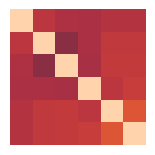

BRCA samples: 1098  biclusters: 255
	biclusters signif. in Cox-PH: 5  Log-Rank: 4 both: 3


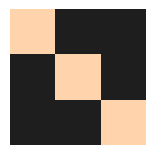

KIRC samples: 531  biclusters: 402
	biclusters signif. in Cox-PH: 99  Log-Rank: 137 both: 85


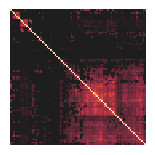

KIRP samples: 289  biclusters: 651
	biclusters signif. in Cox-PH: 23  Log-Rank: 52 both: 14


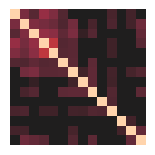

LGG samples: 522  biclusters: 679
	biclusters signif. in Cox-PH: 54  Log-Rank: 47 both: 38


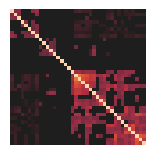

LIHC samples: 371  biclusters: 683
	biclusters signif. in Cox-PH: 7  Log-Rank: 32 both: 7


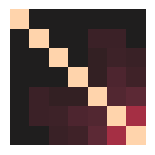

LUAD samples: 515  biclusters: 211
	biclusters signif. in Cox-PH: 14  Log-Rank: 21 both: 13


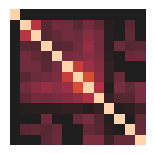

MESO samples: 87  biclusters: 1006
	biclusters signif. in Cox-PH: 11  Log-Rank: 9 both: 9


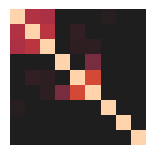

PAAD samples: 179  biclusters: 975
	biclusters signif. in Cox-PH: 2  Log-Rank: 4 both: 2


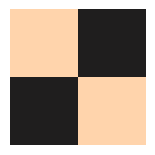

SARC samples: 262  biclusters: 523
	biclusters signif. in Cox-PH: 2  Log-Rank: 5 both: 2


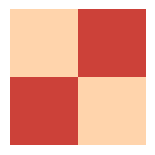

SKCM samples: 469  biclusters: 483
	biclusters signif. in Cox-PH: 5  Log-Rank: 7 both: 5


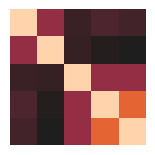

In [25]:
from unpast.utils.consensus import calc_signif_bicluster_similarities
signif_biclusters = []
for f in sorted(os.listdir(bic_path)):
    if "consensus" in f:
        cancer  = f.split(".")[0].replace("_consensus","")
        biclusters = annotated_biclusters.loc[annotated_biclusters["cancer"]==cancer,:]
        annot = pd.read_csv(exprs_path+cancer+".annotation.tsv.gz",index_col=0,sep="\t")
        biclusters.loc[:,["OS.LogR_p_value_BH","OS.p_value_BH"]]= biclusters.loc[:,["OS.LogR_p_value_BH","OS.p_value_BH"]].fillna(1)
        
        df_signif_both = biclusters[biclusters[["OS.LogR_p_value_BH","OS.p_value_BH"]].max(axis=1)<0.05]
        df_signif_LR = biclusters[biclusters["OS.LogR_p_value_BH"]<0.05]
        df_signif_CPH = biclusters[biclusters["OS.p_value_BH"]<0.05]

        stats[cancer]["significant (CPH)"] = df_signif_CPH.shape[0]
        stats[cancer]["significant (log-rank)"] = df_signif_LR.shape[0]
        stats[cancer]["significant (both)"] = df_signif_both.shape[0]
        signif_bic_ids = df_signif_both.index
        if len(signif_bic_ids)>0:
            print(cancer, "samples:",annot.shape[0]," biclusters:",biclusters.shape[0])
            print("\tbiclusters signif. in Cox-PH:",df_signif_CPH.shape[0]," Log-Rank:",df_signif_LR.shape[0],
                  "both:",df_signif_both.shape[0])
            signif_biclusters.append(biclusters.loc[signif_bic_ids,:])
        if len(signif_bic_ids)>1:
            exprs = pd.read_csv(exprs_path+cancer+".exprs.tsv.gz",index_col=0,sep="\t")
            exprs = exprs.loc[passed_ids,:]
            J = calc_signif_bicluster_similarities(biclusters.loc[signif_bic_ids,:].T.to_dict(),
                                                   exprs,
                                                   similarity="samples",plot=True,
                                                   figsize=(2, 2),labels=False)

signif_biclusters = pd.concat(signif_biclusters)

In [26]:
pd.DataFrame.from_dict(stats).T.sort_values("significant (both)",ascending = False)

,n_biclusters,n_samples_>_10s,n_samples,ARI,n_tested_biclusters,significant (CPH),significant (log-rank),significant (both)
KIRC,449.0,426.0,531.0,402.0,402.0,99.0,137.0,85.0
LGG,744.0,712.0,522.0,679.0,679.0,54.0,47.0,38.0
KIRP,877.0,734.0,289.0,651.0,651.0,23.0,52.0,14.0
LUAD,233.0,228.0,515.0,211.0,211.0,14.0,21.0,13.0
MESO,1320.0,1068.0,87.0,1006.0,1006.0,11.0,9.0,9.0
LIHC,777.0,710.0,371.0,683.0,683.0,7.0,32.0,7.0
ACC,1270.0,995.0,77.0,883.0,883.0,6.0,44.0,6.0
SKCM,502.0,493.0,469.0,483.0,483.0,5.0,7.0,5.0
BRCA,285.0,279.0,1098.0,255.0,255.0,5.0,4.0,3.0
PAAD,1084.0,1007.0,179.0,975.0,975.0,2.0,4.0,2.0


In [27]:
pd.DataFrame.from_dict(stats).T["significant (both)"].sum()

184.0

In [94]:
df_A = pd.DataFrame.from_dict(stats).T.sort_values("significant (CPH)",ascending = False)
df_A["all biclusters"] = df_A["n_biclusters"] 
df_A["tested biclusters"] = df_A["ARI"] 
df_A = df_A.loc[:,["all biclusters","tested biclusters","significant (CPH)","significant (log-rank)","significant (both)"]]
df_A = df_A.applymap(lambda x: int(x) if pd.notnull(x) else x)
df_A.head(15)

,all biclusters,tested biclusters,significant (CPH),significant (log-rank),significant (both)
KIRC,449,402.0,99,137,85
LGG,744,679.0,54,47,38
KIRP,877,651.0,23,52,14
LUAD,233,211.0,14,21,13
MESO,1320,1006.0,11,9,9
LIHC,777,683.0,7,32,7
ACC,1270,883.0,6,44,6
SKCM,502,483.0,5,7,5
BRCA,285,255.0,5,4,3
PAAD,1084,975.0,2,4,2


In [29]:
df_B = signif_biclusters.loc[:,:].copy()
df_B = df_B.sort_values(["OS.p_value_BH","n_genes"],ascending=[True,False])
cols = ["genes",'genes_up',"genes_down","samples", "gene_indexes","sample_indexes"]
for col in cols:
    df_B[col] = df_B[col].apply(lambda x: " ".join(map(str,sorted(x))))
df_B.head(3)

,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,...,female.pval_BH,sex.pval_BH,sex,OS.p_value,OS.HR,OS.upper_95CI,OS.lower_95CI,OS.LogR_p_value,OS.p_value_BH,OS.LogR_p_value_BH
LGG_280,1.645061,20,252,ALDH3A2 ANKUB1 CELSR1 CLEC18B CTNNAP1 ECM2 EEF...,TCGA-CS-4938-01 TCGA-CS-4941-01 TCGA-CS-5395-0...,ALDH3A2 ANKUB1 CELSR1 CLEC18B CTNNAP1 ECM2 EEF...,,699 957 3683 4111 4804 5950 6031 9534 10393 10...,1 3 4 5 8 9 12 14 16 17 19 23 24 27 29 33 36 3...,UP,...,1.0,0.872116,,1.240523e-08,2.970066,4.320140,2.041899,5.167057e-07,0.000004,0.000035
LGG_313,1.592756,12,171,HAND2 HAND2-AS1 HOTTIP HOXA10 HOXA10-HOXA9 HOX...,TCGA-CS-4943-01 TCGA-CS-5393-01 TCGA-CS-5395-0...,HAND2 HAND2-AS1 HOTTIP HOXA10 HOXA10-HOXA9 HOX...,,8838 8839 9472 9476 9478 9479 9480 9481 9482 9...,3 5 14 16 19 24 32 38 39 42 43 46 48 49 54 56 ...,UP,...,1.0,1.000000,,8.024446e-09,2.789568,3.953045,1.968531,1.293310e-07,0.000004,0.000010
LGG_115,2.051277,2,254,LHX5 LHX5-AS1,TCGA-CS-4941-01 TCGA-CS-5395-01 TCGA-CS-5397-0...,,LHX5 LHX5-AS1,11561 11562,1 5 9 10 11 14 16 20 23 24 27 29 31 33 36 38 3...,DOWN,...,1.0,1.000000,,1.672332e-08,2.905144,4.207669,2.005828,1.402906e-05,0.000004,0.000560


In [30]:
# Create Excel writer using the openpyxl engine
with pd.ExcelWriter(bic_path+"/OS_biclusters."+'Table_SX.xlsx', engine='openpyxl') as writer:
    # Write an empty DataFrame to the first sheet
    pd.DataFrame().to_excel(writer, sheet_name='description', index=False)
    
    # Write df_A to the second sheet
    df_A.to_excel(writer, sheet_name='Table XSA - statistics', index=True)
    
    # Write df_B to the third sheet
    df_B.to_excel(writer, sheet_name='Table SXB - OS-associated biclusters', index=True)


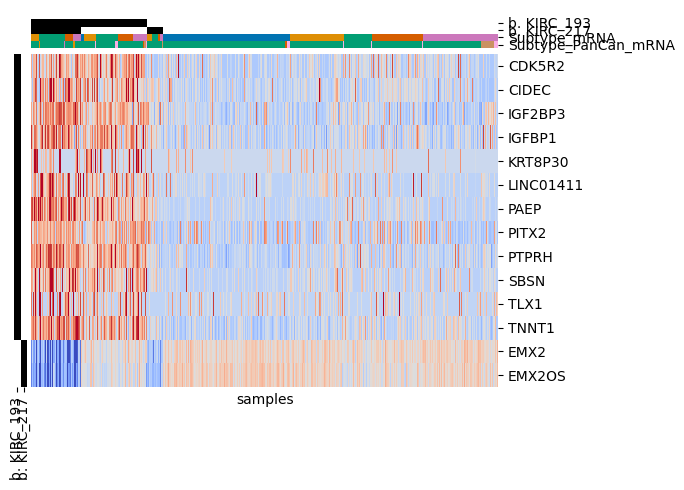

In [31]:
cancer = "KIRC"
i = ["KIRC_193","KIRC_217"]

exprs_z = prepare_input_matrix(pd.read_csv(exprs_path+cancer+".exprs.tsv.gz",index_col=0,sep="\t"),
                               ceiling=3)


a = subtypes.loc[sorted(set(exprs_z.columns).intersection(set(subtypes.index.values))),:].copy()
a = a.loc[:,["Subtype_mRNA","Subtype_PanCan_mRNA"]].T
for s in sorted(set(exprs_z.columns).difference(set(a.columns.values))):
    a[s] = "NA"
a = a.T
color_dict = {}
subts = sorted(set(a["Subtype_PanCan_mRNA"].values))
color_dict["Subtype_PanCan_mRNA"] = dict(zip(subts, sns.color_palette("colorblind", len(subts))))
subts = sorted(set(a["Subtype_mRNA"].values))
color_dict["Subtype_mRNA"] = dict(zip(subts, sns.color_palette("colorblind", len(subts))))

b = all_biclusters.loc[i,:]

tmp = draw_heatmap2(exprs_z,b,
                    annot = a.loc[:,:].copy(), color_dict=color_dict,
              bicluster_colors= "black",
              figsize = (7,5), 
              dendrogram_ratio=(0.01,0.01),
              colors_ratio=(0.02/7*5, 0.02),
              bic_prefix = "b. ",
              #no_legend=True,
              no_cbar=True,
              col_labels = False,
              #row_labels = False,
              row_labels =True,
                no_row_colors = False,
                cluster_rows=False
             )

In [32]:
" ".join(sorted(all_biclusters.loc["KIRC_193","genes"]))

'CDK5R2 CIDEC IGF2BP3 IGFBP1 KRT8P30 LINC01411 PAEP PITX2 PTPRH SBSN TLX1 TNNT1'

# Validate in independent data E-MTAB-1980
* identifying biclusters in E-MTAB-1980 (n=101)
* matching with OS-associated TCGA-KIRC biclusters
* testing matched for OS

In [33]:
exprs_file_KIRC = exprs_path+ "/KIRC.exprs.tsv.gz"
exprs_KIRC=pd.read_csv(exprs_file_KIRC, sep = "\t", index_col=0)
exprs_KIRC_z =prepare_input_matrix(exprs_KIRC,ceiling = 3)

In [34]:
s = "OS"
covariates = ["age","sex","stage_2","stage_3","stage_4"]

KIRC_annot = pd.read_csv(exprs_path+"KIRC"+".annotation.tsv.gz",index_col=0,sep="\t")
KIRC_annot = KIRC_annot.loc[:,covariates+[s,s+".time"]]
KIRC_annot.head(2)

,age,sex,stage_2,stage_3,stage_4,OS,OS.time
sample,,,,,,,
TCGA-3Z-A93Z-01,69.0,0,0.0,0.0,0.0,0.0,385.0
TCGA-6D-AA2E-01,68.0,1,0.0,0.0,0.0,0.0,362.0


In [35]:
# E-MTAB-1980
exprs_file_ccRCC = data_path+ "preprocessed_v6/ccRCC_exp_log_UQ_normalized_collapsed_maxvar4.tsv.gz"
exprs_ccRCC = pd.read_csv(exprs_file_ccRCC, sep = "\t", index_col=0)
shared_genes = set(exprs_KIRC_z.index.values).intersection(set(exprs_ccRCC.index.values))
exprs_ccRCC = exprs_ccRCC.loc[sorted(shared_genes),:]
exprs_file_ccRCC = data_path+"preprocessed_v6/ccRCC_exp_log_UQ_normalized_collapsed_maxvar4.17856_shared_genes.tsv.gz"
exprs_ccRCC.to_csv(exprs_file_ccRCC, sep="\t")
exprs_ccRCC_z = prepare_input_matrix(exprs_ccRCC,ceiling = 3)
print(len(shared_genes))

17856


In [36]:
ccRCC_annot = pd.read_csv(data_path+"preprocessed_v6/E-MTAB-1980.annotation.tsv",index_col=0,sep="\t")
# because only one patient has stage 4, merge stage_3 and _4 into one group
ccRCC_annot["stage_34"] = ccRCC_annot["stage_3"]+ccRCC_annot["stage_4"] 
ccRCC_annot = ccRCC_annot.loc[exprs_ccRCC_z.columns.values,:]
ccRCC_annot[s+".time"] = ccRCC_annot[s]
ccRCC_annot[s] = ccRCC_annot[s+"_event"]
ccRCC_annot = ccRCC_annot.loc[:,[s,s+".time"]+["age","sex","stage_2","stage_34"]]
ccRCC_annot.head(2)

,OS,OS.time,age,sex,stage_2,stage_34
sample ID,,,,,,
ccRCC-1,0,111.0,58.0,1,0,0
ccRCC-2,1,73.0,71.0,0,0,0


### running UnPaSt using independent ccRCC dataset E-MTAB-1980

In [37]:
from unpast.run_unpast import unpast
from unpast.utils.consensus import make_consensus_biclusters
from unpast.utils.method import zscore

In [38]:
basename = 'ccRCCv4_18K'
out_dir = "ccRCC_results/"

In [39]:
ccRCC_biclusters = []
for seed in seeds:
    results = unpast(exprs_file_ccRCC,
                     basename,
                     out_dir=out_dir,
                     rpath="/home/olya/anaconda3/envs/r4_env/bin/",
                     save=True,load=False,
                     seed = seed,
                     verbose = False)
    results.index = ["seed="+str(seed)+"_"+str(x) for x in results.index.values]
    ccRCC_biclusters.append(results)
    print(seed,"n biclusters:", results.shape[0] )


885440 n biclusters: 108
403958 n biclusters: 105
794772 n biclusters: 96
933488 n biclusters: 114
441001 n biclusters: 106


In [40]:
# make consensus biclusters 
for i in range(len(ccRCC_biclusters)):
    print(seeds[i],"n biclusters:", ccRCC_biclusters[i].shape[0] )

ccRCC = make_consensus_biclusters(ccRCC_biclusters,
                                    prepare_input_matrix(pd.read_csv(exprs_file_ccRCC, sep = "\t", index_col=0), ceiling = 3),
                                    seed = analysis_seed,
                                    verbose = True)

885440 n biclusters: 108
403958 n biclusters: 105
794772 n biclusters: 96
933488 n biclusters: 114
441001 n biclusters: 106
7 s for similarity matrix
	Running Louvain ...
		modularity: newman
	curve type: increasing
	Louvain runtime: modules detected in 0.18 s.
	modules: 111, not clustered features 48 
		similarity cutoff: 0.43 modularity: 0.988
keep genes included in at least 2 merged biclusters
all consensus biclusters: 159
detected 2+ times:111
1 s for making consensus biclusters from consensus gene sets


In [41]:
ccRCC_bic_fname = out_dir+"/"+basename +".consensus_seed="+str(analysis_seed)+".biclusters.tsv"
write_bic_table(ccRCC, ccRCC_bic_fname)
#ccRCC = read_bic_table(ccRCC_bic_fname)

In [42]:
KIRC = all_biclusters.loc[all_biclusters["cancer"]=="KIRC",:]
KIRC_OS = signif_biclusters.loc[signif_biclusters["cancer"]=="KIRC",:]

### matching biclusters found in E-MTAB-1980

In [43]:
from unpast.utils.eval import find_best_matching_biclusters

N = len(shared_genes)
bm = find_best_matching_biclusters(KIRC_OS.loc[:,:].copy(),
                                   ccRCC.loc[:,:].copy(),
                                   (N,N))
bm = bm.dropna()
bm.shape[0]

7

In [44]:
pval_cutoff = 0.05
matched_ccRCC = sorted(set(bm.sort_values("n_shared_genes",ascending = False)["bm_id"].values))
df = add_survival(ccRCC.loc[matched_ccRCC,:],
                  ccRCC_annot, 
                  event= "OS", 
                  surv_time ="OS.time",
                  covariates = ['age', 'sex', 'stage_2', 'stage_34']
                 )
df = df.sort_values(by = ["OS.p_value_BH","OS.p_value"])
matched_biclusters_ccRCC = df.loc[df["OS.p_value_BH"]<pval_cutoff,:].index.values
print("passed biclusters from ccRCC:",matched_biclusters_ccRCC)
df.loc[df["OS.p_value_BH"]<pval_cutoff,:]

passed biclusters from ccRCC: [12 42]


,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids,OS.p_value,OS.HR,OS.upper_95CI,OS.lower_95CI,OS.LogR_p_value,OS.p_value_BH,OS.LogR_p_value_BH
12,2.196057,6,27,"{TNNT1, HSP90B3P, PTPRH, IGF2BP3, SSR4, HSP90B1}","{ccRCC-22, ccRCC-46, ccRCC-41, ccRCC-64, ccRCC...","{TNNT1, HSP90B3P, PTPRH, IGF2BP3, SSR4, HSP90B1}",{},"{12257, 15877, 7057, 7058, 14738, 7228}","{1, 8, 9, 21, 23, 25, 29, 31, 32, 39, 43, 44, ...",UP,5,"{seed=933488_20, seed=403958_18, seed=794772_3...",0.008959,3.565193,9.249017,1.374265,6.948376e-06,0.040108,0.000014
42,1.947858,4,15,"{EMX2, PPARGC1A, CDKL2, EMX2OS}","{ccRCC-65, ccRCC-45, ccRCC-41, ccRCC-9, ccRCC-...",{},"{EMX2, EMX2OS, CDKL2, PPARGC1A}","{4723, 4724, 2731, 11743}","{66, 70, 39, 8, 9, 43, 79, 61, 52, 85, 22, 23,...",DOWN,5,"{seed=933488_46, seed=885440_61, seed=441001_1...",0.013369,3.389378,8.915213,1.288571,9.544967e-07,0.040108,0.000006


In [45]:
# their best matches in KIRC 
matched_biclusters_KIRC = bm.loc[bm["bm_id"].isin(df.loc[df["OS.p_value_BH"]<pval_cutoff,:].index)].index.values
print("passed bicluster KIRC:",matched_biclusters_KIRC)
bm.loc[bm["bm_id"].isin(df.loc[df["OS.p_value_BH"]<pval_cutoff,:].index)]

passed bicluster KIRC: ['KIRC_193' 'KIRC_217']


,bm_id,J,adj_pval,genes,n_genes,n_samples,samples,shared_genes,n_shared_genes,bm_genes,bm_n_genes,bm_n_samples,bm_samples,shared_samples,n_shared_samples
KIRC_193,12,0.2,0.0,"{TNNT1, PTPRH, TLX1, KRT8P30, CDK5R2, CIDEC, L...",12,131,"{TCGA-B0-4815-01, TCGA-CJ-4901-01, TCGA-B4-583...","{TNNT1, PTPRH, IGF2BP3}",3,"{TNNT1, HSP90B3P, PTPRH, IGF2BP3, SSR4, HSP90B1}",6,27,"{ccRCC-22, ccRCC-46, ccRCC-41, ccRCC-64, ccRCC...",{},0
KIRC_217,42,0.5,0.0,"{EMX2, EMX2OS}",2,75,"{TCGA-BP-4971-01, TCGA-B0-4815-01, TCGA-A3-334...","{EMX2, EMX2OS}",2,"{EMX2, PPARGC1A, CDKL2, EMX2OS}",4,15,"{ccRCC-65, ccRCC-45, ccRCC-41, ccRCC-9, ccRCC-...",{},0


# Draw heatmaps and KM curves

In [46]:
#bm
ccA = sorted(["MAPT", "STK32B", "FZD1", "RGS5", "GIPC2", "PDGFD", "EPAS1", "MAOB",
    "CDH5", "TCEA3", "LEPROTL1", "BNIP3L", "EHBP1", "VCAM1", "PHYH",
    "PRKAA2", "SLC4A4", "ESD", "TLR3", "NRP1","ST13", "ARNT","DAGLA","SPRYD7"
])  #"C11orf11", "C13orf1"

ccB = sorted([ 
    "SERPINA3", "SLC4A3", "MOXD1", "KCNN4", "ROR2", "QSOX1","UNG",
    "FOXM1", "GALNT10", "GALNT4"
]) #"FLJ23867","UNG2", 

from collections import OrderedDict
color_dict = {}
color_dict["ccA/ccB "] = OrderedDict({"ccB":"magenta","ccA":"green","-":"white"})


In [47]:
ccRCC_subt  = pd.read_csv(data_path+"preprocessed_v6//E-MTAB-1980.annotation.tsv",index_col=0,sep="\t").loc[:,["subt"]]
ccRCC_subt.columns = ["ccA/ccB (published)"]
ccRCC_subt.head(5)

,ccA/ccB (published)
sample ID,
ccRCC-1,ccB
ccRCC-2,ccA
ccRCC-3,ccA
ccRCC-4,ccA
ccRCC-5,ccA


In [48]:
shared_genes = set([])
for bic_id in matched_biclusters_KIRC:
    shared_genes|=bm.loc[bic_id,"shared_genes"]
print(sorted(shared_genes))

['EMX2', 'EMX2OS', 'IGF2BP3', 'PTPRH', 'TNNT1']


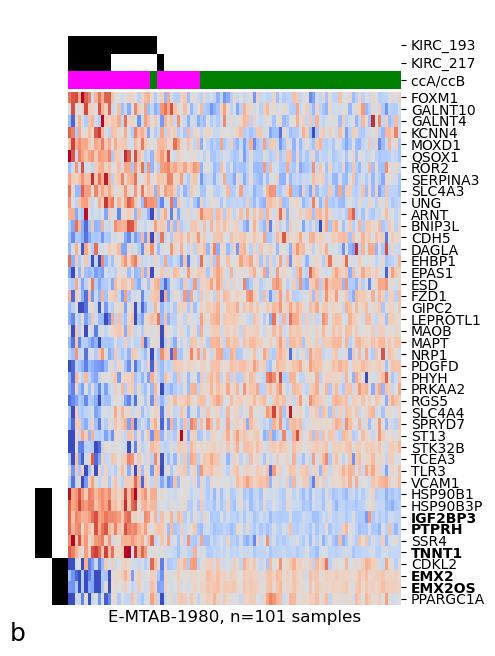

In [49]:
from unpast.utils.method import make_biclusters

b = make_biclusters([ccA+ccB],
                    exprs_ccRCC_z.T,
                    exprs_ccRCC_z,
                    merge=1,
                    min_n_samples=5,
                    min_n_genes=2,
                    method="kmeans",
                    seed=analysis_seed,
                    cluster_binary=False,
                    verbose=True
                   )
b.index = ["ccA/ccB"] 
b.loc[["ccA/ccB"],"genes_up"] = [set(ccB)]
b.loc[["ccA/ccB"],"genes_down"] = [set(ccA)]
b.loc[["ccA/ccB"],"samples"] = [set(ccRCC_subt.loc[ccRCC_subt["ccA/ccB (published)"]=="ccB",:].index.values)]
b.loc[["ccA/ccB"],"n_samples"] = [len(set(ccRCC_subt.loc[ccRCC_subt["ccA/ccB (published)"]=="ccB",:].index.values))]


bics = ccRCC.loc[matched_biclusters_ccRCC,:]
bics.index = matched_biclusters_KIRC 
ccRCC_subt["ccA/ccB "] = ccRCC_subt["ccA/ccB (published)"]
tmp = draw_heatmap2(exprs_ccRCC_z,
                    pd.concat([b,bics]),
                    annot = ccRCC_subt.loc[:,["ccA/ccB "]].copy(), color_dict=color_dict,
                    bicluster_colors= ["white"]*b.shape[0]+["black"]*bics.shape[0],
                    figsize = (5,7), 
                    dendrogram_ratio=(0.01,0.01),
                    colors_ratio=(0.03/5*7, 0.03),
                    bic_prefix = "",
                    #no_legend=True,
                    highlight_row_labels=shared_genes,
                    no_cbar=True,
                    col_labels = False,
                    #row_labels = False,
                    row_labels =True,
                    no_row_colors = False,
                    cluster_rows=False
                    )
ax = tmp[0].ax_heatmap
ax.set_xlabel("E-MTAB-1980, n=%s samples"%exprs_ccRCC_z.shape[1], fontsize=12)
tmp[0].ax_row_colors.set_xticklabels([""]*(bics.shape[0]+b.shape[0]))
tmp[0].ax_row_colors.set_xticks([])
tmp[0].ax_col_colors.set_yticklabels([""]+tmp[0].ax_col_colors.get_yticklabels()[1:])
tmp[0].ax_col_colors.set_yticks(tmp[0].ax_col_colors.get_yticks()[1:])  
tmp[0].ax_heatmap.set_yticklabels(ax.get_yticklabels(),fontsize=10)
tmp[0].fig.text(0.02, 0.07, "b", ha='left', va='bottom', fontsize=18)
plt.show()

In [50]:
from lifelines.plotting import add_at_risk_counts
from lifelines import KaplanMeierFitter, CoxPHFitter

from statsmodels.stats.multitest import fdrcorrection
def plot_KM(biclusters,
            annot,
            surv_results,
            surv_time='_time',
            surv_event='_event',
            cohort = "cohort",
            xlabel = "time units",
            labels_colors = (("high","red"),("low","blue")),
            xticks=[12*x for x in range(0,30)],
            add_counts=False,
            label_pos =(2,0.05),
            figsize=(5,4),
            linestyle='solid',
            add_subplot=False,
           fig_labels={}):
    
    yticks = [0, 0.25,0.5,0.75, 1.0]
    sns.reset_defaults()
    sns.set(font_scale = 0.75,
            style = 'ticks',
            rc = {'axes.edgecolor':'.5',
                'xtick.color':'.25',
                'ytick.color':'.25'}
           )

    for i in biclusters.index.values:
        bic = set(biclusters.loc[i,"samples"]).intersection(set(annot.index.values))
        bg = set(annot.index.values).difference(bic)
        bic = sorted(bic)
        bg = sorted(bg)

        up, down = bic, bg
        up_label , up_color = labels_colors[0]
        down_label , down_color = labels_colors[1]
        if labels_colors == (("high","red"),("low","blue")):
            if biclusters.loc[i,"direction"] == "DOWN":
                up, down = bg, bic
                
        print(i,annot.shape[0],len(up),len(down))

        pv = surv_results.loc[i,"pval"]
        pv_lr = surv_results.loc[i,"pval_lR"]
        hr = surv_results.loc[i,"HR"]
        ci95 = surv_results.loc[i,["CI_l","CI_r"]]
        text = "p = %.2e (Cox PH)\np = %.2e (log-rank)\nHR = %.2f (%.2f,%.2f)"%(pv, pv_lr, hr, ci95[0], ci95[1])
        
        #plt.figure(figsize=figsize)
        #ax = plt.subplots(111)
        fig, ax= plt.subplots(1, 1, figsize=figsize)
        #ax.set_xticks(xticks)

        kmf_1 = KaplanMeierFitter()
        
        ax = kmf_1.fit(annot.loc[up,surv_time],
                       annot.loc[up,surv_event],
                       label= up_label+' (n=%s)'%len(up)
                      ).plot_survival_function(ax=ax, 
                                               color=up_color,
                                               ci_alpha = 0.0,
                                               linestyle=linestyle,
                                               xticks =xticks,
                                               yticks =yticks)

        kmf_2 = KaplanMeierFitter()

        ax = kmf_2.fit(annot.loc[down,surv_time], 
                       annot.loc[down,surv_event],
                       label=down_label+' (n=%s)'%len(down)
                      ).plot_survival_function(ax=ax,
                                               color=down_color,
                                               ci_alpha = 0.0,
                                               linestyle=linestyle,
                                               xticks =xticks,
                                               yticks =yticks) 
        
        if add_counts:
            #from lifelines.plotting import add_at_risk_counts
            add_at_risk_counts(kmf_1, kmf_2, ax=ax)
            ax.set_xlabel(ax.get_xlabel(),
                          ha = "right",
                          fontsize=9
                         )
            plt.tight_layout()
        ax.set_title("%s (n=%s), Bicluster %s"%(cohort, 
                                                    len(up)+len(down),
                                                    i)
                    )
        ax.legend(loc=1, prop={'size': 8})
        if xlabel:
            ax.set_xlabel(xlabel)
        ax.text(label_pos[0],label_pos[1],text,fontsize=8)
        ax.set_ylim(0,1)
        #ax.set_xlim(0,100)
        if len(fig_labels):
            label_pos_x = -0.05
            if add_counts:
                label_pos_x = 0
            fig.text(label_pos_x, 0.15, fig_labels[i], ha='left', va='bottom', fontsize=18)
        
        if not add_subplot:
            plt.show()      
    return fig, ax


In [51]:
bics = ccRCC.loc[matched_biclusters_ccRCC,:]
bics.index = matched_biclusters_KIRC 

ccRCC_surv_results = add_survival(bics, 
                                 ccRCC_annot,
                                  event= "OS",surv_time ="OS.time",
                                  covariates = ['age', 'sex', 'stage_2', 'stage_34']
                                )
ccRCC_surv_results = pd.concat([ccRCC_surv_results,
                               add_survival(b, 
                                 ccRCC_annot,
                                  event= "OS",surv_time ="OS.time",
                                  covariates = ['age', 'sex', 'stage_2', 'stage_34']
                                )])
ccRCC_surv_results["pval"] = ccRCC_surv_results["OS.p_value"] 
ccRCC_surv_results["adj_pval"] = ccRCC_surv_results["OS.p_value_BH"]
ccRCC_surv_results["pval_lR"] = ccRCC_surv_results["OS.LogR_p_value"]
ccRCC_surv_results["HR"] = ccRCC_surv_results["OS.HR"]
ccRCC_surv_results["CI_l"] = ccRCC_surv_results["OS.lower_95CI"]
ccRCC_surv_results["CI_r"] = ccRCC_surv_results["OS.upper_95CI"]
ccRCC_surv_results.loc[:,["pval","adj_pval","pval_lR","HR","CI_l","CI_r"]]

,pval,adj_pval,pval_lR,HR,CI_l,CI_r
KIRC_193,0.008959,0.013369,6.948376e-06,3.565193,1.374265,9.249017
KIRC_217,0.013369,0.013369,9.544967e-07,3.389378,1.288571,8.915213
ccA/ccB,0.027592,0.027592,2.263317e-04,3.027970,1.130026,8.113619


ccA/ccB 101 38 63


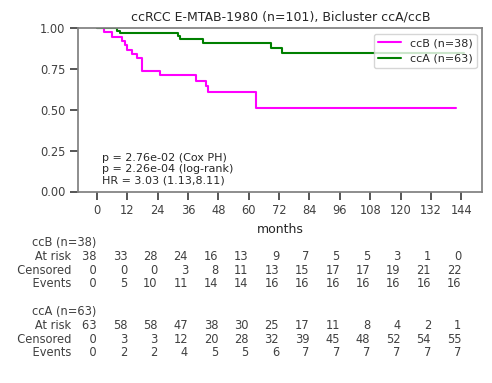

In [52]:
plot_KM(b, 
        ccRCC_annot,
        ccRCC_surv_results,
        surv_time="OS.time",
        surv_event='OS',
        cohort = "ccRCC E-MTAB-1980",
        xlabel = "months",
        labels_colors= (("ccB","magenta"),("ccA","green")),
        xticks=[12*x for x in range(0,30)],
        add_counts=True,
        label_pos =(2,0.05),
        figsize=(5,4),
        linestyle='solid',
        add_subplot=False
       )   
plt.show()

KIRC_193 101 27 74


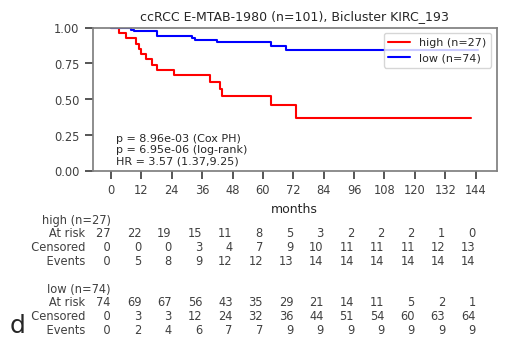

KIRC_217 101 86 15


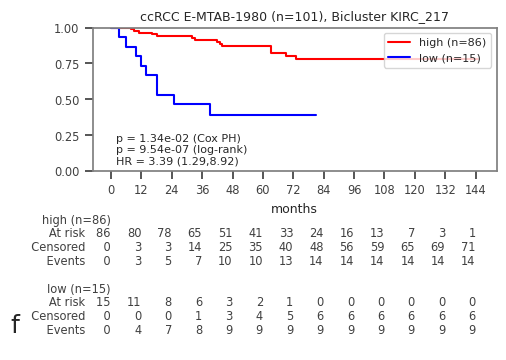

In [53]:
plot_KM(bics,
        ccRCC_annot,
        ccRCC_surv_results,
        surv_time="OS.time",
        surv_event='OS',
        cohort = "ccRCC E-MTAB-1980",
        xlabel = "months",
        #labels_colors= (("ccB","magenta"),("ccA","green")),
        xticks=[12*x for x in range(0,30)],
        add_counts=True,
        label_pos =(2,0.05),
        figsize=(5,3.8),
        linestyle='solid',
        add_subplot=False,
        fig_labels = {"KIRC_193":"d","KIRC_217":"f"}
       )     
plt.show()

### ccRCC E-MTAB-1980: compare subsets of ccB stratified by biclusters

In [54]:
ccB_samples = set(ccRCC_subt.loc[ccRCC_subt["ccA/ccB (published)"]=="ccB",:].index.values)
ccB_samples = sorted(ccB_samples.intersection(set(exprs_ccRCC.columns.values)))
len(ccB_samples)

38

In [55]:
bics = ccRCC.loc[matched_biclusters_ccRCC,:]
bics.index = matched_biclusters_KIRC 
b1 = bics.copy()
b1["samples"] = b1["samples"].apply(lambda x: x.intersection(set(ccB_samples)))
 
ccRCC_surv_results = add_survival(b1, 
                                 ccRCC_annot.loc[ccB_samples,:],
                                  event= "OS",surv_time ="OS.time",
                                  covariates = ['age', 'sex', 'stage_2', 'stage_34']
                                )
ccRCC_surv_results["pval"] = ccRCC_surv_results["OS.p_value"] 
ccRCC_surv_results["adj_pval"] = ccRCC_surv_results["OS.p_value_BH"]
ccRCC_surv_results["pval_lR"] = ccRCC_surv_results["OS.LogR_p_value"]
ccRCC_surv_results["HR"] = ccRCC_surv_results["OS.HR"]
ccRCC_surv_results["CI_l"] = ccRCC_surv_results["OS.lower_95CI"]
ccRCC_surv_results["CI_r"] = ccRCC_surv_results["OS.upper_95CI"]
ccRCC_surv_results.loc[:,["pval","adj_pval","pval_lR","HR","CI_l","CI_r"]]

,pval,adj_pval,pval_lR,HR,CI_l,CI_r
KIRC_193,0.329527,0.329527,0.071929,1.981818,0.501120,7.837649
KIRC_217,0.112792,0.225585,0.013125,2.408771,0.812655,7.139775


KIRC_193 38 25 13


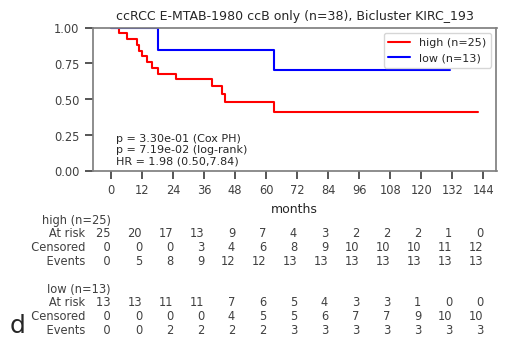

KIRC_217 38 23 15


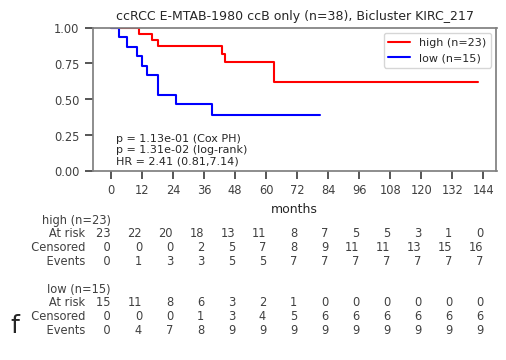

In [56]:
plot_KM(b1,
        ccRCC_annot.loc[ccB_samples,:],
        ccRCC_surv_results,
        surv_time="OS.time",
        surv_event='OS',
        cohort = "ccRCC E-MTAB-1980 ccB only",
        xlabel = "months",
        #labels_colors= (("ccB","magenta"),("ccA","green")),
        xticks=[12*x for x in range(0,30)],
        add_counts=True,
        label_pos =(2,0.05),
        figsize=(5,3.8),
        linestyle='solid',
        add_subplot=False,
        fig_labels = {"KIRC_193":"d","KIRC_217":"f"}
       )     
plt.show()

### ccRCC E-MTAB-1980: Overlap of two biclusters 

In [58]:
i1 = 12
i2 = 42
o = ccRCC.loc[i1,"samples"].intersection(ccRCC.loc[i2,"samples"])
g1  =  ccRCC.loc[i1,"genes"]
g2  =  ccRCC.loc[i2,"genes"]
print("overlap:",len(o))
b2 = make_biclusters([ccB],
    exprs_ccRCC_z.T,
    exprs_ccRCC_z,
    merge=1,
    min_n_samples=5,
    min_n_genes=2,
    method="kmeans",
    seed=analysis_seed,
    cluster_binary=False,
    verbose=True,)
b2.index = ["o"]
b2.loc[["o"],"genes"] = [g1|g2]
b2.loc[["o"],"genes_up"] = [g1]
b2.loc[["o"],"genes_down"] = [g2]
b2.loc[["o"],"samples"] = [o]
b2.loc[["o"],"n_samples"] = [len(o)]

ccRCC_surv_results = add_survival(b2, 
                                 ccRCC_annot,
                                  event= "OS",surv_time ="OS.time",
                                  covariates = ['age', 'sex', 'stage_2', 'stage_34']
                                )
ccRCC_surv_results["pval"] = ccRCC_surv_results["OS.p_value"] 
ccRCC_surv_results["adj_pval"] = ccRCC_surv_results["OS.p_value_BH"]
ccRCC_surv_results["pval_lR"] = ccRCC_surv_results["OS.LogR_p_value"]
ccRCC_surv_results["HR"] = ccRCC_surv_results["OS.HR"]
ccRCC_surv_results["CI_l"] = ccRCC_surv_results["OS.lower_95CI"]
ccRCC_surv_results["CI_r"] = ccRCC_surv_results["OS.upper_95CI"]
ccRCC_surv_results.loc[:,["pval","adj_pval","pval_lR","HR","CI_l","CI_r"]]

overlap: 13


,pval,adj_pval,pval_lR,HR,CI_l,CI_r
o,0.021486,0.021486,0.000003,3.125443,1.183168,8.256133


o 101 13 88


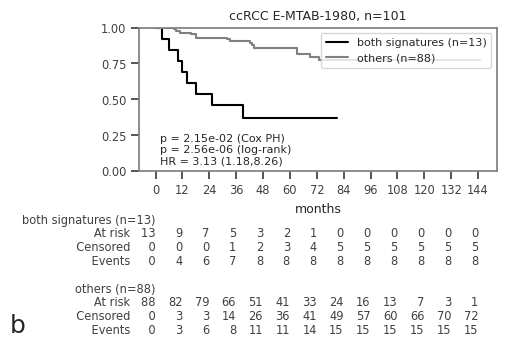

In [59]:
fig, ax = plot_KM(b2,
        ccRCC_annot,
        ccRCC_surv_results,
        surv_time="OS.time",
        surv_event='OS',
        cohort = "ccRCC E-MTAB-1980",
        xlabel = "months",
        labels_colors= (("both signatures","black"),("others","gray")),
        xticks=[12*x for x in range(0,30)],
        add_counts=True,
        label_pos =(2,0.05),
        figsize=(5,3.8),
        linestyle='solid',
        add_subplot=True,
        fig_labels = {"o":"b"}
       )     
ax.set_title("ccRCC E-MTAB-1980, n=%s"%ccRCC_annot.shape[0])
plt.show()

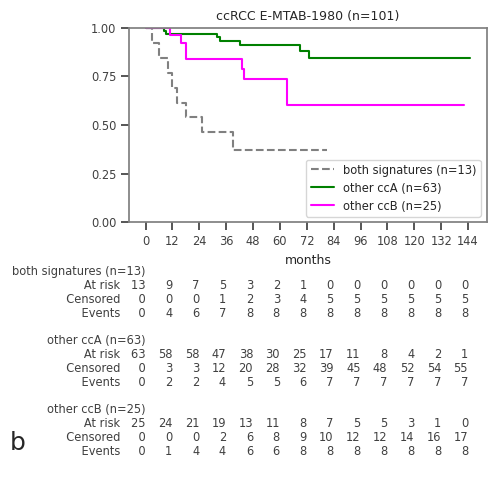

In [60]:
def plot_3KM(samples,subtypes,
            annot,
            surv_results,
            surv_time='_time',
            surv_event='_event',
            cohort = "cohort",
            xlabel = "time units",
            bic_label="",
            bic_color = "grey",
            xticks=[12*x for x in range(0,30)],
            add_counts=False,
            label_pos =(2,0.05),
            figsize=(5,4),
            fig_label=""):
    
    yticks = [0, 0.25,0.5,0.75, 1.0]
    sns.reset_defaults()
    sns.set(font_scale = 0.75,
            style = 'ticks',
            rc = {'axes.edgecolor':'.5',
                'xtick.color':'.25',
                'ytick.color':'.25'}
           )

    bic = set(samples)
    ccA = sorted(set(subtypes[subtypes=="ccA"].index.values).difference(bic))
    ccB = sorted(set(subtypes[subtypes=="ccB"].index.values).difference(bic))
    bic = sorted(bic)
    
    fig, ax= plt.subplots(1, 1, figsize=figsize)

    kmf_1 = KaplanMeierFitter()

    ax = kmf_1.fit(annot.loc[bic,surv_time],
                       annot.loc[bic,surv_event],
                       label= bic_label+' (n=%s)'%len(bic)
                      ).plot_survival_function(ax=ax, 
                                               color=bic_color,
                                               ci_alpha = 0.0,
                                               linestyle="dashed",
                                               xticks =xticks,
                                               yticks =yticks)

    kmf_2 = KaplanMeierFitter()
    ax = kmf_2.fit(annot.loc[ccA,surv_time], 
                   annot.loc[ccA,surv_event],
                   label='other ccA (n=%s)'%len(ccA)
                  ).plot_survival_function(ax=ax,
                                           color="green",
                                           ci_alpha = 0.0,
                                           linestyle="solid",
                                           xticks =xticks,
                                           yticks =yticks) 
    kmf_3 = KaplanMeierFitter()
    ax = kmf_3.fit(annot.loc[ccB,surv_time], 
                   annot.loc[ccB,surv_event],
                   label='other ccB (n=%s)'%len(ccB)
                  ).plot_survival_function(ax=ax,
                                           color="magenta",
                                           ci_alpha = 0.0,
                                           linestyle="solid",
                                           xticks =xticks,
                                           yticks =yticks) 
        
    if add_counts:
        #from lifelines.plotting import add_at_risk_counts
        add_at_risk_counts(kmf_1, kmf_2, kmf_3, ax=ax)
        ax.set_xlabel(ax.get_xlabel(),
                      ha = "right",
                      fontsize=9
                     )
        plt.tight_layout()
    ax.set_title("%s (n=%s)"%(cohort,annot.shape[0]))
    ax.legend(loc=1, prop={'size': 8})
    if xlabel:
        ax.set_xlabel(xlabel)

    ax.set_ylim(0,1)

    if fig_label:
        fig.text(0.02, 0.12, fig_label, ha='left', va='bottom', fontsize=18)

    return fig, ax
fig, ax = plot_3KM(o,
                   ccRCC_subt["ccA/ccB (published)"],
                    ccRCC_annot,
                    ccRCC_surv_results,
                    surv_time="OS.time",
                    surv_event='OS',
                    cohort = "ccRCC E-MTAB-1980",
                    xlabel = "months",
                    bic_label="both signatures",
                    bic_color = "grey",
                    xticks=[12*x for x in range(0,30)],
                    add_counts=True,
                    label_pos =(2,0.05),
                    figsize=(5,5),
                   fig_label="b")
ax.legend(loc='lower right')
plt.show()


# survival in KIRC 

In [62]:
subt_kirc = pd.read_csv("../../data/preprocessed_v6/TCGAPanCan_subtypes/TCGA-KIRC_ccAccB_PMC4058355_TS3.tsv.csv",sep ="\t",index_col=0)
subt_kirc["ccA/ccB (published)"] = subt_kirc["Subtype \nClassification"]

annot_kirc = pd.read_csv(exprs_path+'KIRC'+".annotation.tsv.gz",index_col=0,sep="\t")
annot_kirc["patient_id"] = annot_kirc.index
annot_kirc["patient_id"] = annot_kirc["patient_id"].apply(lambda x: "-".join(x.split("-")[:-1]))
subt_kirc = annot_kirc.merge(subt_kirc.loc[:,["ccA/ccB (published)"]], left_on="patient_id",right_index=True, how="outer")
subt_kirc = subt_kirc.loc[:,["ccA/ccB (published)"]]
subt_kirc = subt_kirc.fillna("-")
subt_kirc.head(3)

,ccA/ccB (published)
sample,
TCGA-3Z-A93Z-01,-
TCGA-6D-AA2E-01,-
TCGA-A3-3306-01,ccA


In [63]:
# read pamr predicted subtypes for ICGC
subt_kirc2 = pd.read_csv("TCGA_KIRC.34genes_151samples.ClearCode34_subtypes.tsv", sep = "\t",index_col=1)
subt_kirc2["ccA/ccB (pamr)"] = "ccA"
subt_kirc2.loc[subt_kirc2["pred_subt"]==2,"ccA/ccB (pamr)"] = "ccB"
subt_kirc2 = subt_kirc2.loc[:,["ccA/ccB (pamr)"]]
subt_kirc2.index = [x.replace(".","-") for x in subt_kirc2.index]
subt_kirc2.head()

,ccA/ccB (pamr)
TCGA-3Z-A93Z-01,ccA
TCGA-6D-AA2E-01,ccB
TCGA-A3-3326-01,ccA
TCGA-A3-3346-01,ccB
TCGA-A3-3376-01,ccA


In [64]:
subt_kirc["ccA/ccB "] = subt_kirc["ccA/ccB (published)"]
subt_kirc#.loc[subt_kirc["ccA/ccB "]=="-",:]

,ccA/ccB (published),ccA/ccB
sample,,
TCGA-3Z-A93Z-01,-,-
TCGA-6D-AA2E-01,-,-
TCGA-A3-3306-01,ccA,ccA
TCGA-A3-3307-01,ccA,ccA
TCGA-A3-3308-01,ccB,ccB
...,...,...
TCGA-MM-A563-01,-,-
TCGA-MM-A564-01,-,-
TCGA-MM-A84U-01,-,-


In [65]:
subt_kirc["ccA/ccB "] = subt_kirc["ccA/ccB (published)"]
subt_kirc.loc[subt_kirc["ccA/ccB "]=="-","ccA/ccB "] = subt_kirc2.loc[subt_kirc.loc[subt_kirc["ccA/ccB "]=="-",:].index,"ccA/ccB (pamr)"]
subt_kirc = subt_kirc.loc[:,["ccA/ccB "]] 
subt_kirc

,ccA/ccB
sample,
TCGA-3Z-A93Z-01,ccA
TCGA-6D-AA2E-01,ccB
TCGA-A3-3306-01,ccA
TCGA-A3-3307-01,ccA
TCGA-A3-3308-01,ccB
...,...
TCGA-MM-A563-01,ccB
TCGA-MM-A564-01,ccB
TCGA-MM-A84U-01,ccB


In [66]:
from unpast.utils.figs import draw_heatmap2

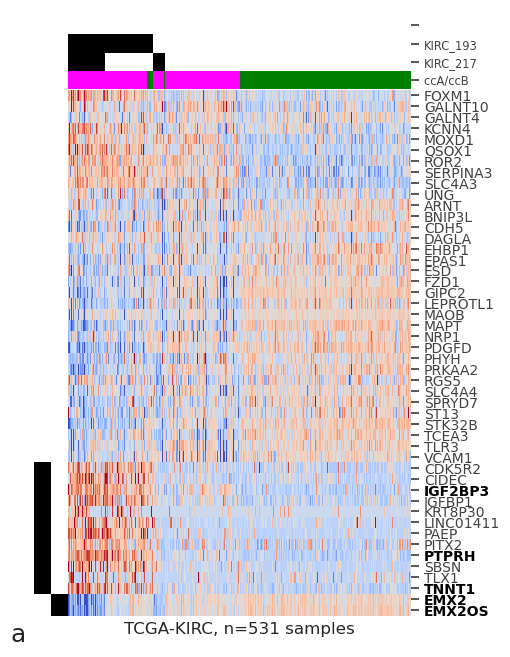

In [67]:
b = make_biclusters([ccA+ccB],
    exprs_KIRC_z.T,
    exprs_KIRC_z,
    merge=1,
    min_n_samples=5,
    min_n_genes=2,
    method="kmeans",
    seed=analysis_seed,
    cluster_binary=False,
    verbose=True,)
b.index = ["ccA/ccB"]
b.loc[["ccA/ccB"],"genes_up"] = [set(ccB)]
b.loc[["ccA/ccB"],"genes_down"] = [set(ccA)]
b.loc[["ccA/ccB"],"samples"] = [set(subt_kirc.loc[subt_kirc["ccA/ccB "]=="ccB",:].index.values)]
b.loc[["ccA/ccB"],"n_samples"] = [len(set(subt_kirc.loc[subt_kirc["ccA/ccB "]=="ccB",:].index.values))]

bics = KIRC.loc[matched_biclusters_KIRC,:]

tmp = draw_heatmap2(exprs_KIRC_z,
                    pd.concat([b,bics]),
                    annot = subt_kirc.loc[:,["ccA/ccB "]].copy(), 
                    color_dict=color_dict,
                    bicluster_colors= ["white"]*b.shape[0]+["black"]*bics.shape[0],
                    figsize = (5,7), 
                    dendrogram_ratio=(0.01,0.01),
                    colors_ratio=(0.03/5*7, 0.03),
                    bic_prefix = "",
                    #no_legend=True,
                    highlight_row_labels=shared_genes,
                    no_cbar=True,
                    col_labels = False,
                    #row_labels = False,
                    row_labels =True,
                    no_row_colors = False,
                    cluster_rows=False
                    )
ax = tmp[0].ax_heatmap
ax.set_xlabel("TCGA-KIRC, n=%s samples"%exprs_KIRC_z.shape[1], fontsize=12)
tmp[0].ax_row_colors.set_xticklabels([""]*(bics.shape[0]+b.shape[0]))
tmp[0].ax_row_colors.set_xticks([])
tmp[0].ax_col_colors.set_yticklabels([""]+tmp[0].ax_col_colors.get_yticklabels()[1:])
#tmp[0].ax_col_colors.set_yticks(tmp[0].ax_col_colors.get_yticks()[1:])  
tmp[0].ax_heatmap.set_yticklabels(ax.get_yticklabels(),fontsize=10)
tmp[0].fig.text(0.02, 0.07, "a", ha='left', va='bottom', fontsize=18)
plt.show()

In [68]:
kirc_surv_results = add_survival(KIRC.loc[matched_biclusters_KIRC,:], 
                                 annot_kirc,
                                event= "OS",surv_time ="OS.time",
                                covariates = ['age', 'sex', 'stage_2', 'stage_3', 'stage_4']
                                )
subtyped_samples = subt_kirc.loc[subt_kirc["ccA/ccB "]!="-",:].index.values
kirc_surv_results = pd.concat([kirc_surv_results,
                               add_survival(b, 
                                 annot_kirc.loc[subtyped_samples,:],
                                event= "OS",surv_time ="OS.time",
                                covariates = ['age', 'sex', 'stage_2', 'stage_3', 'stage_4']
                                )
                              ])
kirc_surv_results["pval"] = kirc_surv_results["OS.p_value"] 
kirc_surv_results["adj_pval"] = kirc_surv_results["OS.p_value_BH"]
kirc_surv_results["pval_lR"] = kirc_surv_results["OS.LogR_p_value"]
kirc_surv_results["HR"] = kirc_surv_results["OS.HR"]
kirc_surv_results["CI_l"] = kirc_surv_results["OS.lower_95CI"]
kirc_surv_results["CI_r"] = kirc_surv_results["OS.upper_95CI"]
kirc_surv_results.loc[:,["pval","adj_pval","pval_lR","HR","CI_l","CI_r"]]

,pval,adj_pval,pval_lR,HR,CI_l,CI_r
KIRC_193,0.000020,0.000040,2.064244e-12,2.019029,1.461828,2.788616
KIRC_217,0.000929,0.000929,8.954451e-09,1.828189,1.279173,2.612839
ccA/ccB,0.000030,0.000030,7.751092e-07,1.975131,1.434971,2.718621


In [69]:
KIRC_annot["OS.time.months"] = KIRC_annot["OS.time"].apply(lambda x: x/30.4)

ccA/ccB 531 256 275


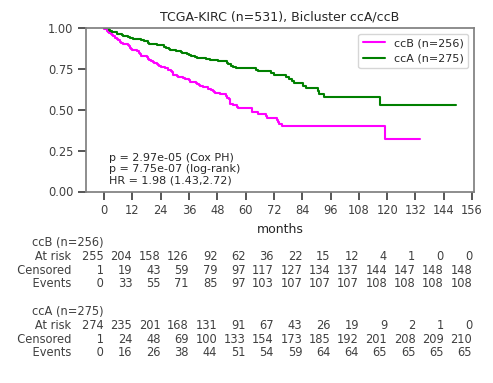

In [70]:
plot_KM(b, 
        KIRC_annot.loc[subtyped_samples,:],
        kirc_surv_results,
        surv_time="OS.time.months",
        surv_event='OS',
        cohort = "TCGA-KIRC",
        xlabel = "months",
        labels_colors= (("ccB","magenta"),("ccA","green")),
        xticks=[12*x for x in range(0,30)],
        add_counts=True,
        label_pos =(2,0.05),
        figsize=(5,4),
        linestyle='solid',
        add_subplot=False
       )   
plt.show()

KIRC_193 531 132 399


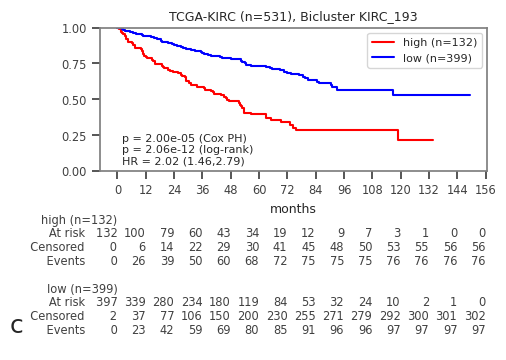

KIRC_217 531 456 75


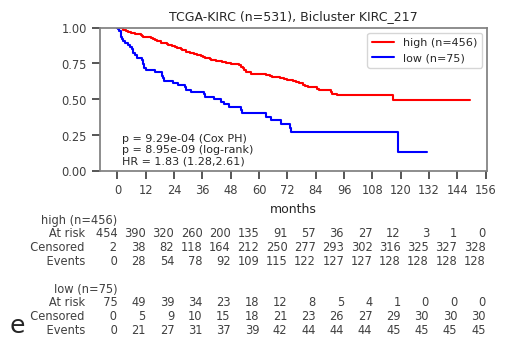

In [71]:
plot_KM(KIRC.loc[matched_biclusters_KIRC,:],
        KIRC_annot,
        kirc_surv_results,
        surv_time="OS.time.months",
        surv_event='OS',
        cohort = "TCGA-KIRC",
        xlabel = "months",
        #labels_colors= (("ccB","magenta"),("ccA","green")),
        xticks=[12*x for x in range(0,30)],
        add_counts=True,
        label_pos =(2,0.05),
        figsize=(5,3.8),
        linestyle='solid',
        add_subplot=False,
        fig_labels = {"KIRC_193":"c","KIRC_217":"e"}
       )   
plt.show()

### KIRC: Compare subsets of ccB stratified by biclusters

In [72]:
annot_kirc['stage_34'] = annot_kirc['stage_3']+annot_kirc['stage_4']  
kirc_surv_results = add_survival(KIRC.loc[matched_biclusters_KIRC,:], 
                                 annot_kirc.loc[subt_kirc.loc[subt_kirc["ccA/ccB "]=="ccB"].index,:],
                                event= "OS",surv_time ="OS.time",
                                covariates = ['age', 'sex', 'stage_2', 'stage_3',"stage_4"]
                                )
kirc_surv_results["pval"] = kirc_surv_results["OS.p_value"] 
kirc_surv_results["adj_pval"] = kirc_surv_results["OS.p_value_BH"]
kirc_surv_results["pval_lR"] = kirc_surv_results["OS.LogR_p_value"]
#kirc_surv_results["adj_pval_lR"] = kirc_surv_results["OS.LogR_p_value_BH"]
kirc_surv_results["HR"] = kirc_surv_results["OS.HR"]
kirc_surv_results["CI_l"] = kirc_surv_results["OS.lower_95CI"]
kirc_surv_results["CI_r"] = kirc_surv_results["OS.upper_95CI"]
kirc_surv_results.sort_values(["OS.p_value","OS.LogR_p_value"]).loc[:,["pval","adj_pval","pval_lR","HR","CI_l","CI_r"]]

,pval,adj_pval,pval_lR,HR,CI_l,CI_r
KIRC_193,0.042344,0.079353,0.000014,1.575605,1.015836,2.443831
KIRC_217,0.079353,0.079353,0.000194,1.436206,0.958482,2.152036


KIRC_193 256 123 133


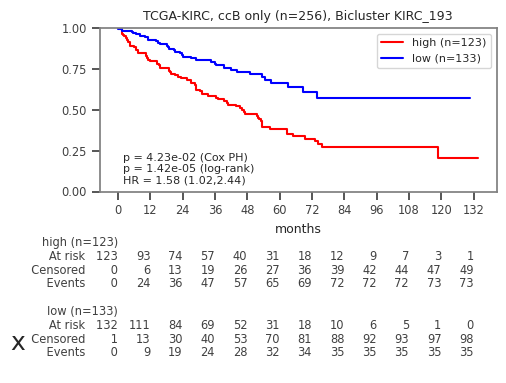

KIRC_217 256 182 74


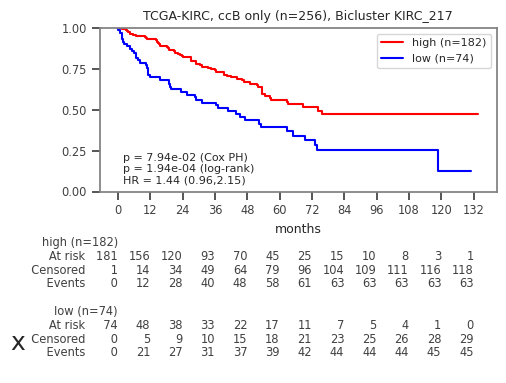

In [73]:
plot_KM(KIRC.loc[matched_biclusters_KIRC,:],
        KIRC_annot.loc[subt_kirc.loc[subt_kirc["ccA/ccB "]=="ccB"].index,:],
        kirc_surv_results,
        surv_time="OS.time.months",
        surv_event='OS',
        cohort = "TCGA-KIRC, ccB only",
        xlabel = "months",
        xticks=[12*x for x in range(0,30)],
        add_counts=True,
        label_pos =(2,0.05),
        figsize=(5,4),
        linestyle='solid',
        add_subplot=False,
        fig_labels = {"KIRC_193":"x","KIRC_217":"x"}
       )   
plt.show()

###  KIRC: Overlap of two biclusters 

In [74]:
i1 = "KIRC_193"
i2 = "KIRC_217"
o = KIRC.loc[i1,"samples"].intersection(KIRC.loc[i2,"samples"])
g1  =  KIRC.loc[i1,"genes"]
g2  =  KIRC.loc[i2,"genes"]
print("overlap:",len(o))
b2 = make_biclusters([ccB],
    exprs_KIRC_z.T,
    exprs_KIRC_z,
    merge=1,
    min_n_samples=5,
    min_n_genes=2,
    method="kmeans",
    seed=analysis_seed,
    cluster_binary=False,
    verbose=True,)
b2.index = ["o"]
b2.loc[["o"],"genes"] = [g1|g2]
b2.loc[["o"],"genes_up"] = [g1]
b2.loc[["o"],"genes_down"] = [g2]
b2.loc[["o"],"samples"] = [o]
b2.loc[["o"],"n_samples"] = [len(o)]

kirc_surv_results = add_survival(b2, 
                                 annot_kirc,
                                event= "OS",surv_time ="OS.time",
                                covariates = ['age', 'sex', 'stage_2', 'stage_3', 'stage_4']
                                )
kirc_surv_results["pval"] = kirc_surv_results["OS.p_value"] 
kirc_surv_results["adj_pval"] = kirc_surv_results["OS.p_value_BH"]
kirc_surv_results["pval_lR"] = kirc_surv_results["OS.LogR_p_value"]
kirc_surv_results["HR"] = kirc_surv_results["OS.HR"]
kirc_surv_results["CI_l"] = kirc_surv_results["OS.lower_95CI"]
kirc_surv_results["CI_r"] = kirc_surv_results["OS.upper_95CI"]
kirc_surv_results.loc[:,["pval","adj_pval","pval_lR","HR","CI_l","CI_r"]]

overlap: 57


,pval,adj_pval,pval_lR,HR,CI_l,CI_r
o,0.000825,0.000825,7.768468e-10,1.904942,1.305746,2.779104


o 531 57 474


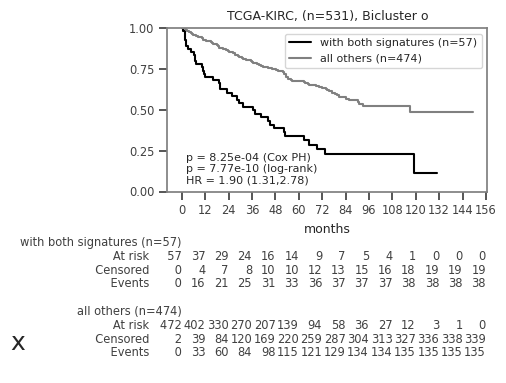

In [75]:
plot_KM(b2,
        KIRC_annot,
        kirc_surv_results,
        surv_time="OS.time.months",
        surv_event='OS',
        cohort = "TCGA-KIRC,",
        xlabel = "months",
        xticks=[12*x for x in range(0,30)],
        add_counts=True,
        label_pos =(2,0.05),
        figsize=(5,4),
        linestyle='solid',
        add_subplot=False,
        labels_colors= (("with both signatures","black"),("all others","gray")),
        fig_labels = {"o":"x"}
       )   
plt.show()

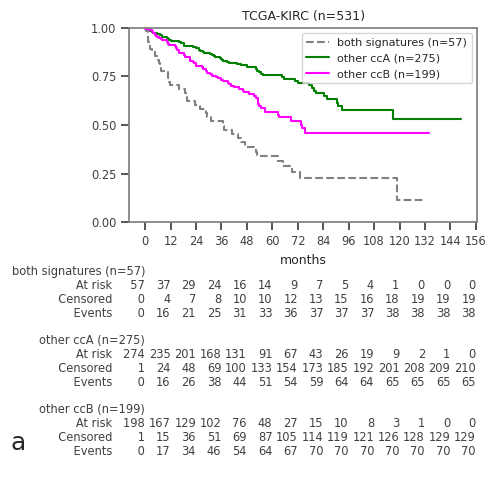

In [76]:
fig, ax = plot_3KM(o,
                   subt_kirc["ccA/ccB "],
                    KIRC_annot,
                    kirc_surv_results,
                    surv_time="OS.time.months",
                    surv_event='OS',
                    cohort = "TCGA-KIRC",
                    xlabel = "months",
                    bic_label="both signatures",
                    bic_color = "grey",
                    xticks=[12*x for x in range(0,30)],
                    add_counts=True,
                    label_pos =(2,0.05),
                    figsize=(5,5),
                   fig_label="a")
#ax.legend(loc='lower right')
plt.show()

# ICGC RECA-EU

* expression n=91 
* OS and covariates n=71

In [77]:
exprs_file_icgc= data_path+"_ICGC/RECA-EU/RECA-EU.24Kgenes_91_specimens_tumor_only.UQlog2_exprs.tsv"
exprs_icgc = pd.read_csv(exprs_file_icgc, sep = "\t", index_col=0)
shared_genes = set(exprs_icgc.index).intersection(set(exprs_KIRC.index.values))
print(len(shared_genes))
exprs_icgc = exprs_icgc.loc[shared_genes,:]
exprs_icgc["gene"] = exprs_icgc.index
exprs_icgc = exprs_icgc.groupby("gene").agg("mean")
exprs_icgc_z = prepare_input_matrix(exprs_icgc,ceiling = 3)
exprs_file_icgc=data_path+"_ICGC/RECA-EU/RECA-EU.24Kgenes_91_specimens_tumor_only.UQlog2_exprs.23848_genes_zscores.tsv"
exprs_icgc_z.to_csv(exprs_file_icgc,sep="\t")

23848


In [78]:
basename = 'ICGC_RECA-EU_23K'
out_dir = "ccRCC_results/"

In [79]:
ICGC_biclusters = []
for seed in seeds:
    results = unpast(exprs_file_icgc,
                     basename,
                     out_dir=out_dir,
                     rpath="/home/olya/anaconda3/envs/r4_env/bin/",
                     save=True,load=False,
                     seed = seed,
                     verbose = False)
    results.index = ["seed="+str(seed)+"_"+str(x) for x in results.index.values]
    ICGC_biclusters.append(results)
    print(seed,"n biclusters:", results.shape[0] )


885440 n biclusters: 268
403958 n biclusters: 214
794772 n biclusters: 302
933488 n biclusters: 372
441001 n biclusters: 229


In [80]:
# make consensus biclusters 
for i in range(len(ICGC_biclusters)):
    print(seeds[i],"n biclusters:", ICGC_biclusters[i].shape[0] )

ICGC = make_consensus_biclusters(ICGC_biclusters,
                                    exprs_icgc_z,
                                    seed = analysis_seed,
                                    verbose = True)

885440 n biclusters: 268
403958 n biclusters: 214
794772 n biclusters: 302
933488 n biclusters: 372
441001 n biclusters: 229
50 s for similarity matrix
	Running Louvain ...
		modularity: newman
	curve type: increasing
	Louvain runtime: modules detected in 0.60 s.
	modules: 313, not clustered features 385 
		similarity cutoff: 0.68 modularity: 0.996
keep genes included in at least 2 merged biclusters
all consensus biclusters: 707
detected 2+ times:298
4 s for making consensus biclusters from consensus gene sets


In [81]:
from unpast.utils.eval import find_best_matching_biclusters

shared_genes = set(exprs_icgc.index).intersection(set(exprs_KIRC.index.values))
N = len(shared_genes)
bm = find_best_matching_biclusters(KIRC_OS.loc[:,:].copy(),
                                   ICGC.loc[:,:].copy(),
                                   (N,N))
bm = bm.dropna()
bm.shape[0]

12

In [82]:
subt_icgc = pd.read_csv("../../data/_ICGC/RECA-EU/RECA-EU.donor.survival.tsv",sep = '\t',index_col=0)
subt_icgc = subt_icgc.fillna("NA")
subt_icgc["age"] = subt_icgc["donor_age_at_diagnosis"]
d = {"male":0,"female":1,"NA":np.nan}
subt_icgc["sex"] = subt_icgc["donor_sex"].apply(lambda x: d[x])
d = {"deceased":1,"alive":0,"NA":np.nan}
subt_icgc["OS"] = subt_icgc["donor_vital_status"].apply(lambda x: d[x])
subt_icgc["OS.time"] = subt_icgc["donor_survival_time"]
subt_icgc = subt_icgc.loc[:,["age","sex","OS","OS.time"]].dropna()
subt_icgc["donor_id"] = subt_icgc.index
subt_icgc.head()

,age,sex,OS,OS.time,donor_id
icgc_donor_id,,,,,
DO47068,48,0,1.0,1685.0,DO47068
DO47064,49,1,0.0,1432.0,DO47064
DO47072,64,0,1.0,789.0,DO47072
DO47056,54,0,0.0,2104.0,DO47056
DO47060,68,0,0.0,1942.0,DO47060


In [83]:
df = pd.read_csv("../../data/_ICGC/RECA-EU/icgc-dataset-1685627387338/specimen.tsv.gz",sep = '\t',index_col=0)
df = df.loc[:,["icgc_donor_id","tumour_stage"]]
df['icgc_specimen_id'] = df.index
df = df.loc[sorted(set(exprs_icgc.columns).intersection(set(df.index))),:]
df["stage"] = np.nan
df["tumour_stage"] = df["tumour_stage"].fillna("NA")
for i in range(1,5):
    df.loc[df["tumour_stage"].str.startswith("T"+str(i)),"stage"] = i
    if i >1:
        df["stage_"+str(i)] = 0
        df.loc[df["stage"]==i,"stage_"+str(i)] = 1
df= df.merge(subt_icgc, left_on = "icgc_donor_id", right_index=True )
df.loc[df["stage"].isna(),['stage_2','stage_3', 'stage_4']] = np.nan
cols = ['age','sex','OS','OS.time','stage', 'stage_2','stage_3'] #  'stage_4' - no samples
annot_icgc = df.loc[:,cols]
annot_icgc.head(5)

,age,sex,OS,OS.time,stage,stage_2,stage_3
icgc_specimen_id,,,,,,,
SP102719,67,0,1.0,782.0,3.0,0.0,1.0
SP102727,54,0,1.0,564.0,3.0,0.0,1.0
SP102735,77,1,0.0,2044.0,1.0,0.0,0.0
SP102743,55,0,1.0,2.0,NaN,NaN,NaN
SP102749,52,1,1.0,978.0,1.0,0.0,0.0


In [84]:
ICGC_OS  = add_survival(ICGC.loc[bm["bm_id"].values,:], annot_icgc.dropna(),
             event= "OS",surv_time ="OS.time",
             covariates = ['age', 'sex', 'stage_2', 'stage_3']
            ).head(3).sort_values("OS.LogR_p_value")

df = ICGC_OS.sort_values(by = ["OS.p_value_BH","OS.p_value"])
matched_biclusters_ccRCC = df.loc[df["OS.p_value_BH"]<pval_cutoff,:].index.values
print("passed biclusters from ccRCC:",matched_biclusters_ccRCC)
df.loc[df["OS.p_value_BH"]<pval_cutoff,:]

perfect separation for biclsuter of  5/66 samples variances: 0.00 0.09


zero variance for events in group; all events are  {0.0}


perfect separation for biclsuter of  7/64 samples variances: 0.00 0.12


zero variance for events in group; all events are  {0.0}
passed biclusters from ccRCC: []


,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids,OS.p_value,OS.HR,OS.upper_95CI,OS.lower_95CI,OS.LogR_p_value,OS.p_value_BH,OS.LogR_p_value_BH


#### apply pamr method 
* default parameters, v1.57
* training: 380 labelled samples from TCGA-KIRC; 34 ClearCode genes

In [85]:
### save input for pamr
# training TCGA-KIRC
subt_kirc = pd.read_csv("../../data/preprocessed_v6/TCGAPanCan_subtypes/TCGA-KIRC_ccAccB_PMC4058355_TS3.tsv.csv",sep ="\t",index_col=0)
subt_kirc["ccA/ccB (published)"] = subt_kirc["Subtype \nClassification"]
annot_kirc = pd.read_csv(exprs_path+'KIRC'+".annotation.tsv.gz",index_col=0,sep="\t")
annot_kirc["patient_id"] = annot_kirc.index
annot_kirc["patient_id"] = annot_kirc["patient_id"].apply(lambda x: "-".join(x.split("-")[:-1]))
subt_kirc = annot_kirc.merge(subt_kirc.loc[:,["ccA/ccB (published)"]], left_on="patient_id",right_index=True, how="outer")
subt_kirc = subt_kirc.loc[:,["ccA/ccB (published)"]]
subt_kirc = subt_kirc.fillna("-")


exprs_icgc.loc[ccB+ccA,:].to_csv("ICGC-RECA.34genes_91samples.tsv")
exprs_KIRC.loc[ccB+ccA,subt_kirc.loc[subt_kirc["ccA/ccB (published)"]!="-",:].index.values].to_csv("TCGA_KIRC.34genes_380samples.tsv")
exprs_KIRC.loc[ccB+ccA,subt_kirc.loc[subt_kirc["ccA/ccB (published)"]=="-",:].index.values].to_csv("TCGA_KIRC.34genes_151samples_unlabelled.tsv")
df = subt_kirc.loc[subt_kirc["ccA/ccB (published)"]!="-",:]
df["subt"] = 1
# target: ICGC RECA-EU
df.loc[df["ccA/ccB (published)"]=="ccB","subt"] = 2
df.to_csv("TCGA_KIRC.380samples.ClearCode34_subtypes.tsv")

In [ ]:
### R code - not run ### 
#library("pamr")
#kirc_data <- as.matrix(read.csv("TCGA_KIRC.34genes_380samples.tsv",row.names=1))
#kirc_subtypes <- read.csv("TCGA_KIRC.380samples.ClearCode34_subtypes.tsv")$subt
#kirc <- list(x=kirc_data,y=kirc_subtypes)
#trained <- pamr.train(kirc)
#not_labelled_data <- as.matrix(read.csv("ICGC-RECA.34genes_91samples.tsv",row.names=1))
#pred_subt <- pamr.predict(trained, not_labelled_data , threshold=1)
#pred_subt <- t(rbind(colnames(not_labelled_data), pred_subt))
#write.table(pred_subt, file = "ICGC-RECA.91samples.ClearCode34_subtypes.tsv", append = FALSE, quote = FALSE, sep = "\t")

In [86]:
# read pamr predicted subtypes for ICGC
subt_icgc = pd.read_csv("ICGC-RECA.91samples.ClearCode34_subtypes.tsv", sep = "\t",index_col=1)
subt_icgc["ccA/ccB (pamr)"] = "ccA"
subt_icgc.loc[subt_icgc["pred_subt"]==2,"ccA/ccB (pamr)"] = "ccB"
subt_icgc = subt_icgc.loc[:,["ccA/ccB (pamr)"]]
subt_icgc.head()

,ccA/ccB (pamr)
SP102719,ccA
SP102727,ccA
SP102735,ccB
SP102743,ccB
SP102749,ccB


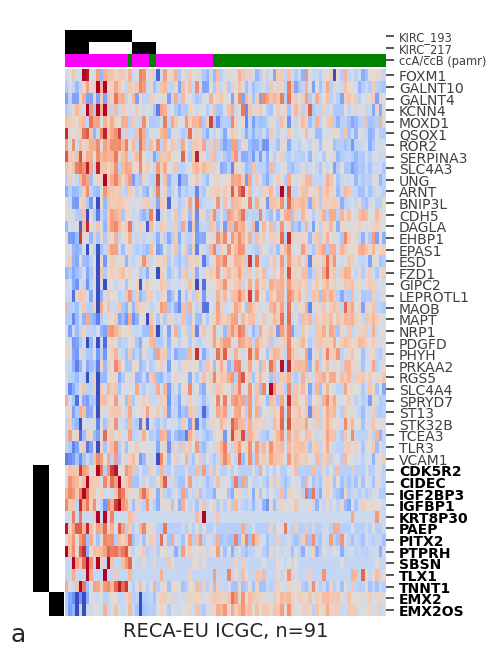

In [88]:
bics = make_biclusters([ccA+ccB,
                    sorted(KIRC.loc["KIRC_193","genes"].intersection(exprs_icgc_z.index)),
                     sorted(KIRC.loc["KIRC_217","genes"].intersection(exprs_icgc_z.index)),
                    ],
    exprs_icgc_z.T,
    exprs_icgc_z,
    merge=1,
    min_n_samples=5,
    min_n_genes=2,
    method="kmeans",
    seed=analysis_seed,
    cluster_binary=False,
    verbose=True,)
bics.index = ["KIRC_193","ccA/ccB","KIRC_217"]
bics.loc[["ccA/ccB"],"genes_up"] = [set(ccB)]
bics.loc[["ccA/ccB"],"genes_down"] = [set(ccA)]
bics.loc[["ccA/ccB"],"samples"] = [set(subt_icgc.loc[subt_icgc["ccA/ccB (pamr)"]=="ccB",:].index.values)]
bics.loc[["ccA/ccB"],"n_samples"] = [len(set(subt_icgc.loc[subt_icgc["ccA/ccB (pamr)"]=="ccB",:].index.values))]

color_dict["ccA/ccB (pamr)"] = color_dict["ccA/ccB "]
tmp = draw_heatmap2(exprs_icgc_z,
                    bics.loc[["ccA/ccB","KIRC_193","KIRC_217"],:],
                    annot = subt_icgc.loc[:,["ccA/ccB (pamr)"]].copy(), 
                    color_dict=color_dict,
                    bicluster_colors= ["white","black","black"],#["white"]*b.shape[0]+["black"]*bics.shape[0],
                    figsize = (5,7), 
                    dendrogram_ratio=(0.01,0.01),
                    colors_ratio=(0.03/5*7, 0.02),
                    bic_prefix = "",
                    #no_legend=True,
                    highlight_row_labels=KIRC.loc["KIRC_193","genes"]|KIRC.loc["KIRC_217","genes"],
                    no_cbar=True,
                    col_labels = False,
                    #row_labels = False,
                    row_labels =True,
                    no_row_colors = False,
                    cluster_rows=False
                    )
ax = tmp[0].ax_heatmap
ax.set_xlabel("RECA-EU ICGC, n=%s"%exprs_icgc_z.shape[1], fontsize=14)
tmp[0].ax_row_colors.set_xticklabels([""]*bics.loc[["ccA/ccB","KIRC_193","KIRC_217"],:].shape[0])
tmp[0].ax_row_colors.set_xticks([])
tmp[0].ax_col_colors.set_yticklabels([""]+tmp[0].ax_col_colors.get_yticklabels()[1:])
tmp[0].ax_col_colors.set_yticks(tmp[0].ax_col_colors.get_yticks()[1:])  
tmp[0].ax_heatmap.set_yticklabels(ax.get_yticklabels(),fontsize=10)
tmp[0].fig.text(0.02, 0.07, "a", ha='left', va='bottom', fontsize=18)
plt.show()

In [89]:
annot_icgc["OS.time.months"] = annot_icgc["OS.time"].apply(lambda x: x/30.4)
icgc_surv_results = add_survival(bics.loc[["KIRC_193","KIRC_217"],:], 
                                 annot_icgc.dropna(),
                                event= "OS",surv_time ="OS.time.months",
                                covariates = ['age', 'sex', 'stage_2', 'stage_3']
                                )
icgc_surv_results = pd.concat([icgc_surv_results,
                               add_survival(bics.loc[["ccA/ccB"],:], 
                                 annot_icgc.dropna(),
                                event= "OS",surv_time ="OS.time.months",
                                covariates = ['age', 'sex', 'stage_2', 'stage_3']
                                )])

icgc_surv_results["pval"] = icgc_surv_results["OS.p_value"] 
icgc_surv_results["adj_pval"] = icgc_surv_results["OS.p_value_BH"]
icgc_surv_results["pval_lR"] = icgc_surv_results["OS.LogR_p_value"]
#icgc_surv_results["adj_pval_lR"] = icgc_surv_results["OS.LogR_p_value_BH"]
icgc_surv_results["HR"] = icgc_surv_results["OS.HR"]
icgc_surv_results["CI_l"] = icgc_surv_results["OS.lower_95CI"]
icgc_surv_results["CI_r"] = icgc_surv_results["OS.upper_95CI"]
icgc_surv_results.sort_values(["OS.p_value","OS.LogR_p_value"]).loc[:,["pval","adj_pval","pval_lR","HR","CI_l","CI_r"]]

,pval,adj_pval,pval_lR,HR,CI_l,CI_r
ccA/ccB,0.365842,0.365842,0.491312,1.494849,0.625423,3.572897
KIRC_193,0.859180,0.957587,0.863434,0.901075,0.285098,2.847913
KIRC_217,0.957587,0.957587,0.563816,1.028084,0.370447,2.853189


KIRC_193 71 14 57


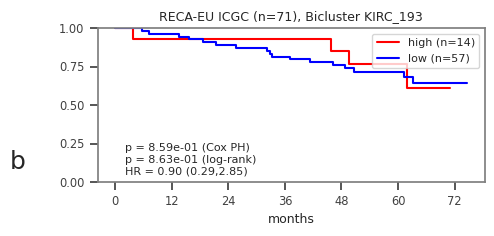

KIRC_217 71 59 12


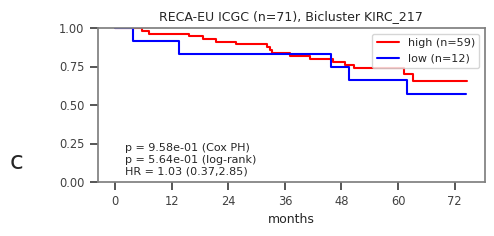

In [90]:
plot_KM(bics.loc[["KIRC_193","KIRC_217"],:],
        annot_icgc.dropna(),
        icgc_surv_results,
        surv_time="OS.time.months",
        surv_event='OS',
        cohort = "RECA-EU ICGC",
        xlabel = "months",
        #labels_colors= (("ccB","magenta"),("ccA","green")),
        xticks=[12*x for x in range(30)],
        add_counts=False,
        label_pos =(2,0.05),
        figsize=(5,2),
        linestyle='solid',
        add_subplot=False,
        fig_labels = {"KIRC_193":"b","KIRC_217":"c"}
       )   
plt.show()

ccA/ccB 71 33 38


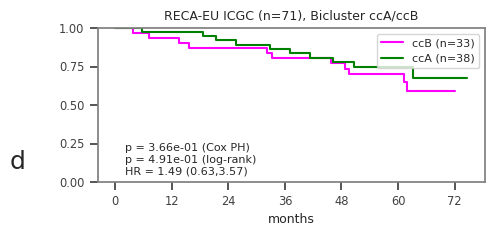

In [91]:
plot_KM(bics.loc[["ccA/ccB"],:],
        annot_icgc.dropna(),
        icgc_surv_results,
        surv_time="OS.time.months",
        surv_event='OS',
        cohort = "RECA-EU ICGC",
        xlabel = "months",
        labels_colors= (("ccB","magenta"),("ccA","green")),
        xticks=[12*x for x in range(30)],
        add_counts=False,
        label_pos =(2,0.05),
        figsize=(5,2),
        linestyle='solid',
        add_subplot=False,
        fig_labels = {"ccA/ccB":"d"}
       )   
plt.show()